In [1]:
import numpy as np
import pandas as pd
import matplotlib
print(matplotlib.__version__)
matplotlib.use('PDF')
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.lines as mlines
from glob import glob
from collections import Counter
import ns
import history_cmc as hic
import math
import scipy
from scipy import stats
from scipy.optimize import bisect
from scipy import integrate
import matplotlib.cm as cm
import matplotlib as mpl
import random
from random import shuffle
import json
import scripts
import scripts1
import scripts2
import scripts3
import dynamics as dyn
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

import unit_convert as uc
import merger_rate_calculator as mr
import ns_tidalcapture as tc
import psr_catalog as pc
import ns_history as nh
import LISA_calculations as lisa_calc

import os, sys
from scipy.interpolate import interp1d
from scipy.stats import lognorm
from scipy.stats import maxwell
import astropy.units as u
from astropy.cosmology import Planck15, z_at_value


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

matplotlib.rcParams.update({'font.size': 24})
#from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
#rc('font',**{'family':'serif','serif':['Times']})
#plt.rcParams['font.family'] = 'serif'
#plt.rcParams['font.serif'] = 'Times New Roman'
#plt.rc('font', family='serif')
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

twopi=2.*np.pi
yearsc=3.1557*10**7
Kconst=9.87*10**-48 ##yr/G^2
Gconst=6.674*10**-8 ##cm3*g-1*s-2
Gconst_sun = 4.30091*10**(-3) ##pc*M_sun**-1*(km/s)2
Gconst_mkgs = 6.6743*10**(-11) ##m^3 kg^-1 s^-2
clight=3*10**10 ##cm/s
clight_km=3*10**5 ##cm/s
Msun=2*10**33 ##gram
Rsun=6.957e10 ##cm
AU=1.496*10**13  ##cm
AU_Rsun=214.93946938362 ##AU to R_sun
PC=3.086*10**18  ##cm
PC_Rsun = 44334448.0068964 ##pc to R_sun
PC_AU = 206265 ##pc to AU

Gconst_pc = Gconst_sun/(PC/10.**5)**2

savepath = '/projects/b1095/syr904/projects/IMBH-WD-TDE/plots/'

2.1.2


In [2]:
def Tl(order, polytropicindex, eta):
    l=order; n=polytropicindex; x=np.log10(eta); x2=x*x; x3=x*x2; x4=x2*x2; x5=x2*x3

    if l != 2 and l != 3:
        print("unknown order")
    
    ##From Portegies Zwart & Meinen 1993
    if n == 1.5:
        if l == 2: 
            return pow(10.0, -0.397 + 1.678*x + 1.277*x2 - 12.42*x3 + 9.446*x4 - 5.550*x5)
        else:
            return pow(10.0, -0.909 + 1.574*x + 12.37*x2 - 57.40*x3 + 80.10*x4 - 46.43*x5)
                
    elif n == 2.0:
        if l == 2:
            return pow(10.0, -0.517 - 0.906*x + 23.88*x2 - 93.49*x3 + 112.3*x4 - 44.15*x5)
        else:
            return pow(10.0, -1.040 - 1.354*x + 37.64*x2 - 139.9*x3 + 168.2*x4 - 66.53*x5)
                
    elif n == 3.0:
        if l == 2:
            return pow(10.0, -1.124 + 0.877*x - 13.37*x2 + 21.55*x3 - 16.48*x4 + 4.124*x5)
        else:
            return pow(10.0, -1.703 + 2.653*x - 14.34*x2 + 12.85*x3 - 0.492*x4 - 3.600*x5)
                
    else:
        print("unknown polytropic index")
             
        

def E_oscillate(rperi, Mosc, Rosc, nosc, Mpert):
    eta=math.sqrt(Mosc/(Mosc+Mpert))*pow(rperi/Rosc, 1.5)
    #rperi = Rosc*pow((Mosc+Mpert)/Mosc,1/3)*pow(eta, 2/3)

    return Gconst_sun*PC_Rsun*Mpert**2/Rosc * (pow(Rosc/rperi, 6.0) * Tl(2, nosc, eta) + pow(Rosc/rperi, 8.0) * Tl(3, nosc, eta))
  
print(E_oscillate(10, 0.6, 1.2, 1.5, 100))

4226.710242426287


In [3]:
##Calculating the cross section and the velocity dispersion
def Sigma_V(r_pos, M_smbh):
    sigma_v = np.sqrt(Gconst_sun*M_smbh/r_pos)
    return sigma_v

print(Sigma_V(1.72, 4e6))


def Sigma_Cap(Rcap, Mimbh, Mwd, Msmbh, r_pos):
    #r_pos in pc
    qratio = Mwd/Mimbh
    sigma_v = np.sqrt(Gconst_sun*Msmbh/r_pos)
    sigma_cap = np.pi*Rcap**2*(1+(2*Gconst_sun*Mimbh*(1+qratio)/Rcap/sigma_v**2))  ##Rcap in pc
    
    return sigma_cap

print(Sigma_Cap(30*0.0128/PC_Rsun, 1000, 0.6, 4*10**6, 1.72)*PC_Rsun**2)

100.01058083557842
46024.14441568598


In [4]:
##radius of influence
eta = 0.0758 ##Msun*(km/s)^-4
def Rsmbh(Msmbh): ##in pc
    return Gconst_sun*math.sqrt(eta)*Msmbh**0.5
    #return 3.14*(Msmbh/(4.*10**6))**0.543
print(Rsmbh(1e6))
    
##White dwarf radius as a funciton of mass
def R_WD(M_WD):
    M_ch = 1.44
    R_WD = max(1.4e-5, 0.0115*math.sqrt((M_ch/M_WD)**(2/3)-(M_WD/M_ch)**(2/3)))
    
    return R_WD

print(R_WD(0.6))


##WD number density distribution around a SMBH
def N_WD(Msmbh, r_pos):
    rinf = Rsmbh(Msmbh)   ##in pc
    ninf_ms = 1.38e5*math.sqrt(1e6/Msmbh)   ##pc^-3
    ninf_wd = ninf_ms*0.1
    alpha_wd = 1.4
    n_wd = ninf_wd*pow(r_pos/rinf,-alpha_wd)
    return n_wd

print(N_WD(10**6, 0.86))

1.184117930600656
0.012778467098439529
21594.0546012757


In [5]:
##Find the fraction of WDs in a plummer sphere without mass segregation
##mass loss from stellar evolution
def star_evolv(t_current, mulim, M_init, m_tot_kroupa):
    alpha = [-1.3, -2.3]
    m_break = 0.5
    coeff_low = 1; coeff_high=m_break**(-alpha[1]+alpha[0])
    m_to = (10/t_current)**0.4  ##solar mass
    mass_wd=0
    if m_to > 30:
        m_se = 0.9*integrate.quad(lambda x: x*x**alpha[1], m_to, mulim)[0]
        
    elif m_to > 8 and mulim > 30:
        m_se1 = 0.9*integrate.quad(lambda x: x*x**alpha[1], 30, mulim)[0]
        m_se2 = integrate.quad(lambda x: (x-1.4)*x**alpha[1], m_to, 30)[0]
        m_se = m_se1+m_se2

    elif m_to > 8 and mulim <= 30:
        m_se = integrate.quad(lambda x: (x-1.4)*x**alpha[1], m_to, mulim)[0]

    elif m_to > 1 and mulim > 8:
        m_se1 = integrate.quad(lambda x: (x-1.4)*x**alpha[1], 8, mulim)[0]
        m_se2 = integrate.quad(lambda x: (x-(0.109*x+0.394))*x**alpha[1], m_to, 8)[0]
        m_wd = integrate.quad(lambda x: (0.109*x+0.394)*x**alpha[1], m_to, 8)[0]
        mass_wd = coeff_high*m_wd/m_tot_kroupa*M_init
        m_se = m_se1+m_se2

    elif m_to >1 and mulim <=8:
        m_se = integrate.quad(lambda x: (x-(0.109*x+0.394))*x**alpha[1], m_to, mulim)[0]
        m_wd = integrate.quad(lambda x: (0.109*x+0.394)*x**alpha[1], m_to, mulim)[0]
        mass_wd = coeff_high*m_wd/m_tot_kroupa*M_init


    elif m_to >0.08 and mulim >1:
        m_se = integrate.quad(lambda x: (x-(0.109*x+0.394))*x**alpha[1], 1, mulim)[0]

    elif m_to >0.08 and mulim <=1:
        m_se = 0

    else:
        print('error', m_to, mulim)
        
    m_frac = coeff_high*m_se/m_tot_kroupa
    m_ml = m_frac*M_init

    return m_ml, m_to, mass_wd

##Kroupa01 IMF; mmin=0.08, mmax=150
alpha = [-1.3, -2.3]
m_break = 0.5
coeff_low = 1; coeff_high=m_break**(-alpha[1]+alpha[0])
mlow = coeff_low*integrate.quad(lambda x: x*x**alpha[0], 0.08, m_break)[0]
mhigh = coeff_high*integrate.quad(lambda x: x*x**alpha[1], m_break, 150)[0]
m_tot_k = mlow+mhigh

t_array = np.linspace(0, 12, 3000)
mup_lim = 150; minit = 1e5
m_wd_tot=0; m_new = minit
for ii in range(1,len(t_array)):
    m_se, m_turnoff, Mwd = star_evolv(t_array[ii], mup_lim, minit, m_tot_k)
    m_new = m_new-m_se
    mup_lim = m_turnoff
    m_wd_tot+=Mwd
    
print(m_wd_tot/m_new)

0.17372886153365436


In [6]:
##Make a plummer sphere potential
def plummer_density(r, Mclu, b):
    rho_p = 3*Mclu/(2*twopi*b**3)*pow(1+r**2/b**2, -5./2.)
    return rho_p

def plummer_sigma_v(r,Mclu,b):
    sigma_v_p = math.sqrt(Gconst_sun*Mclu/(6*math.sqrt(r**2+b**2)))
    return sigma_v_p

print(plummer_sigma_v(0,2e5,1))

##number density of WDs in a plummer sphere
##Assume WDs are all 0.6 solar mass
def N_WD_plummer(r, wd_frac, Mclu, b):
    rho_p = 3*Mclu/(2*twopi*b**3)*pow(1+r**2/b**2, -5./2.)
    nwd_p = wd_frac*rho_p/0.6
    return nwd_p

print(N_WD_plummer(0,0.2,2e6,0.25))

def plummer_sigma_cap(Rcap, Mimbh, Mwd, Mclu, b, r_pos):
    #r_pos in pc
    qratio = Mwd/Mimbh
    sigma_v_p = math.sqrt(Gconst_sun*Mclu/(6*math.sqrt(r_pos**2+b**2)))
    sigma_cap_p = np.pi*Rcap**2*(1+(2*Gconst_sun*Mimbh*(1+qratio)/Rcap/sigma_v_p**2))
    return sigma_cap_p

11.973456755117407
10185916.357881304


5371868.859624432


/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: overflow encountered in double_scalars
/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:35: RuntimeWarning: overflow encountered in double_scalars
/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: overflow encountered in double_scalars


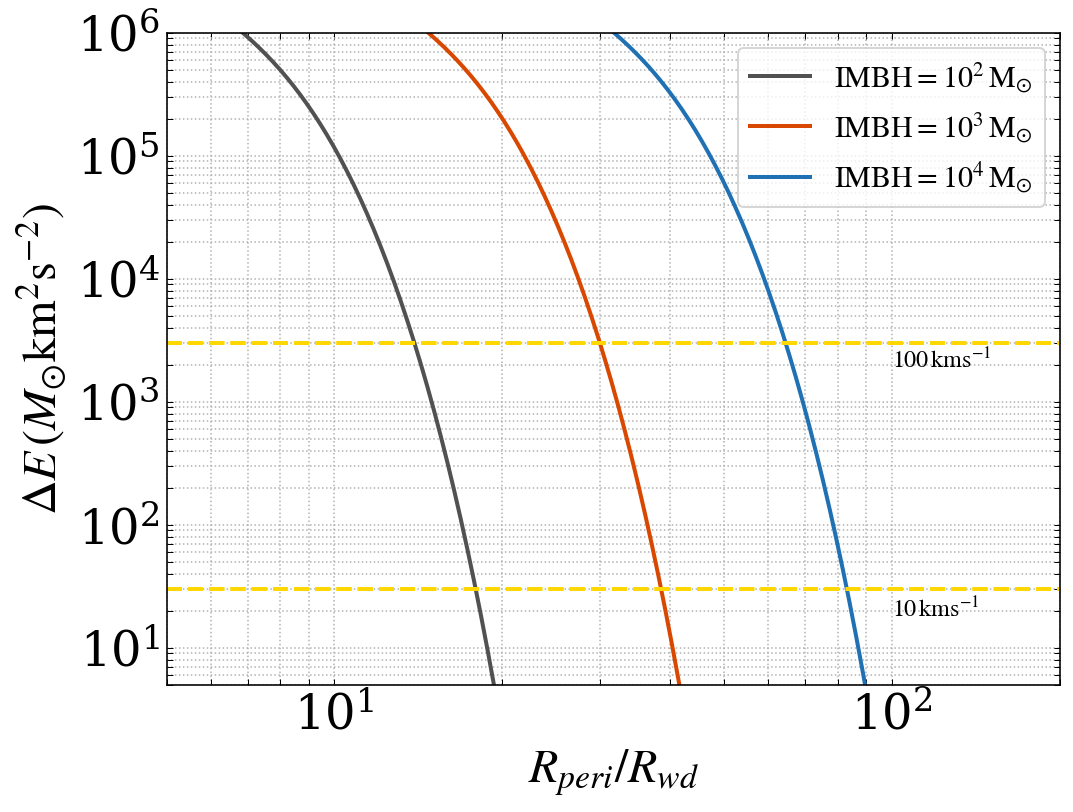

In [7]:
##E_osc vs. r_peri
M_wd = 0.6; R_wd = R_WD(0.6); n_wd=1.5
M_imbh=[1e2, 1e3, 1e4]
M_imbh_label=['10^2', '10^3', '10^4']

E_bind = Gconst_sun*M_wd**2/(R_wd/PC_Rsun)
print(E_bind)

cs = [[],[],[]]
cs[0]=cm.Greys(np.linspace(0.5, 1, 3))
cs[1]=cm.Oranges(np.linspace(0.5, 1, 3))
cs[2]=cm.Blues(np.linspace(0.5, 1, 3))

rperi_array = np.logspace(np.log10(1), np.log10(1001), 500)  ##in unit of R_wd
fig, ax = plt.subplots(figsize=(8,6))
for ii in range(len(M_imbh)):
    delta_E = []
    for xx in range(len(rperi_array)):
        delta_E.append(E_oscillate(rperi_array[xx]*R_wd, M_wd, R_wd, n_wd, M_imbh[ii]))
    ax.plot(rperi_array, delta_E, c=cs[ii][1], lw=2,
           label=r'$\rm{IMBH=}%s\,M_{\odot}$'%M_imbh_label[ii])
    ax.axhline(y=0.5*M_imbh[1]*M_wd/(M_imbh[1]+M_wd)*10**2, lw=2, ls='--', color='gold')
    ax.axhline(y=0.5*M_imbh[1]*M_wd/(M_imbh[1]+M_wd)*100**2, lw=2, ls='--', color='gold')
    
#ax.axhline(y=E_bind, lw=2, ls=':', color='k')
    
ax.set_xlim(5,200)
ax.set_ylim(5,1e6)

ax.text(100, 1900, r'$100\,\rm{km s^{-1}}$', fontsize=12)
ax.text(100, 18, r'$10\,\rm{km s^{-1}}$', fontsize=12)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$R_{peri}/R_{wd}$')
ax.set_ylabel(r'$\Delta E\,(M_{\odot}\rm{km^2 s^{-2}})$')
ax.legend(loc='best', fontsize=15)
plt.grid(linestyle=':',which='major',linewidth='0.75')
plt.grid(linestyle=':',which='minor',linewidth='0.75')
plt.gca().xaxis.set_ticks_position('both')
plt.gca().yaxis.set_ticks_position('both')
plt.tick_params('both',length=3,width=0.5,which='both',direction = 'in')

plt.savefig(savepath+'Eosc_Rperi.pdf', dpi=300)

In [6]:
##Calculate the tidal disruption radii and the minimum sma and ecc after tidal capture
M_wd = 0.6; R_wd = R_WD(0.6); n_wd=1.5
M_imbh=[1e2, 1e3, 1e4]

def sma_ecc(Mimbh):
    print((Mimbh/M_wd)**(1./3.))
    Eb = E_oscillate((Mimbh/M_wd)**(1./3.)*R_wd, M_wd, R_wd, n_wd, Mimbh)
    print(Eb)
    sma = Gconst_sun*Mimbh*M_wd/(2.*Eb)*PC_AU ##in AU
    sma_rsun = Gconst_sun*Mimbh*M_wd/(2.*Eb)*PC_Rsun  ##in units of solar radius
    ecc = 1-(Mimbh/M_wd)**(1./3.)*R_wd/sma_rsun
    
    print(sma, sma_rsun, ecc)

for ii in range(len(M_imbh)):
    sma_ecc(M_imbh[ii])

5.503212081491045
2164403.98198484
0.012296140764855796 2.642923488837072 0.9733921111163111
11.856311014966874
2157030.124914133
0.12338175404740553 26.519583835427145 0.9942870340215813
25.543647746451768
2154310.212683689
1.2353752898634949 265.53065986695606 0.9987707307982223


[array([[0.58608228, 0.58608228, 0.58608228, 1.        ],
       [0.31741638, 0.31741638, 0.31741638, 1.        ],
       [0.        , 0.        , 0.        , 1.        ]]), array([[0.99141869, 0.55072664, 0.23277201, 1.        ],
       [0.84627451, 0.28069204, 0.00410611, 1.        ],
       [0.49803922, 0.15294118, 0.01568627, 1.        ]]), array([[0.41708574, 0.68063053, 0.83823145, 1.        ],
       [0.12710496, 0.44018454, 0.70749712, 1.        ],
       [0.03137255, 0.18823529, 0.41960784, 1.        ]])]


/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: overflow encountered in double_scalars
/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: overflow encountered in double_scalars


3.2738870610657647
2.9275801295250026
2.55087719445139
[[5.8236111022522226e-05, 5.8236111022522226e-05, 5.97878789956401e-05], [0.0005891435720923665, 0.0005891435720923665, 0.0005891435720923665], [0.005805359788111303, 0.005960050258224142, 0.005960050258224142]]
(3, 3, 500)


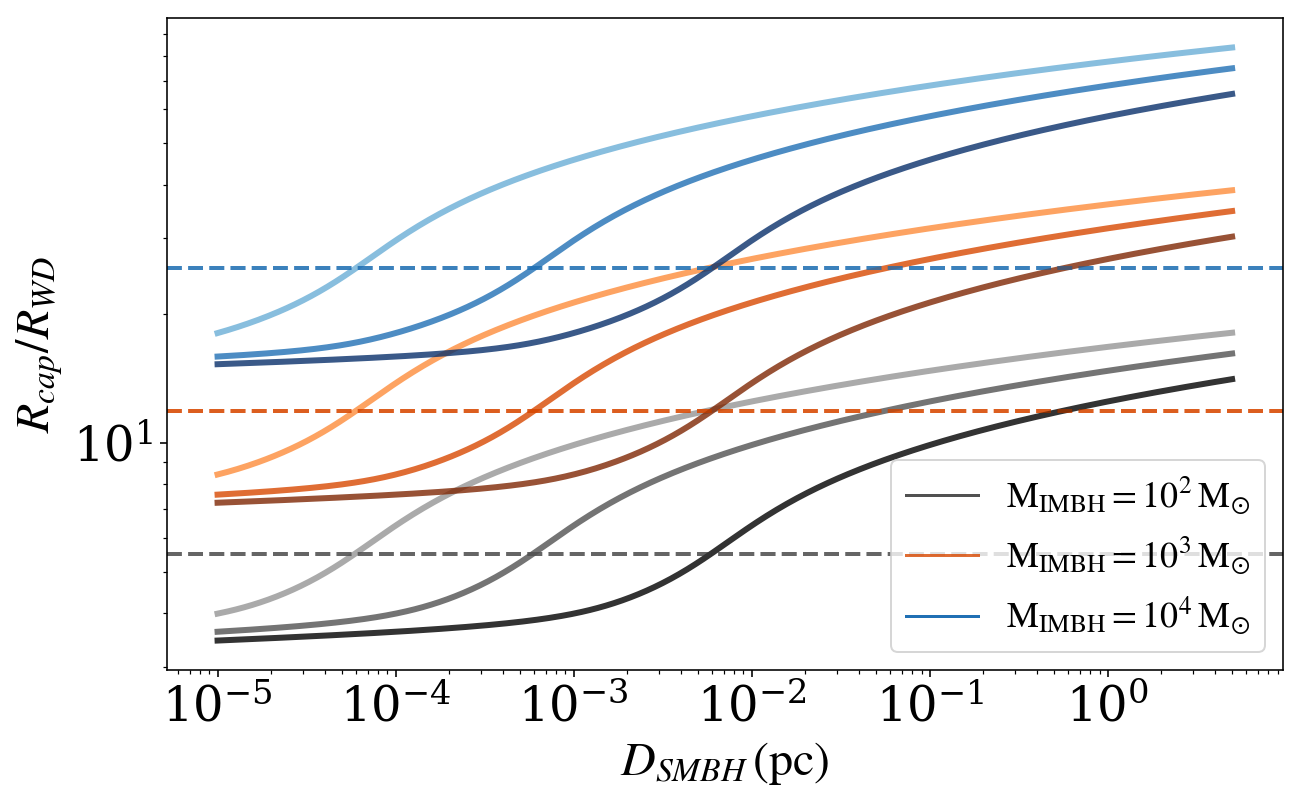

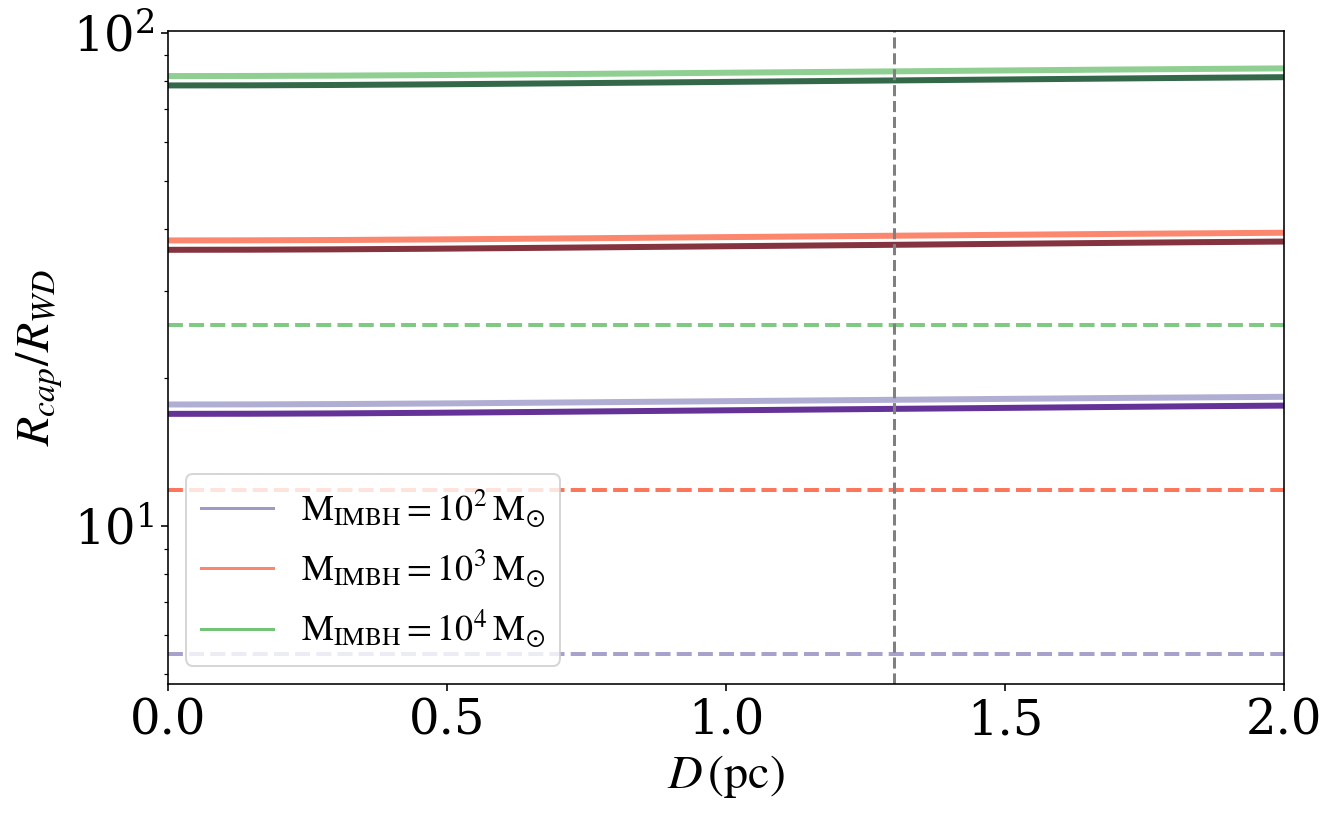

In [7]:
##R_cap as a function of the distance to the SMBH
M_smbh = [1e5,1e6,1e7]
bparams=1
M_plummer = [2e5,5e5]
M_wd = 0.6; R_wd = R_WD(0.6); n_wd=1.5
M_imbh=[100, 1000, 1e4]
d_array = np.logspace(np.log10(0.00001), np.log10(5), 500) ##for distances to the SMBH in pc
test_range=np.linspace(1,200,100)  ##for pericenter distance in WD radius

cs = [[],[],[]]
cs[0]=cm.Greys(np.linspace(0.5, 1, 3))
cs[1]=cm.Oranges(np.linspace(0.5, 1, 3))
cs[2]=cm.Blues(np.linspace(0.5, 1, 3))
print(cs)

############################################################
##For galactic center
R_cap_smbh = [[],[],[]]
cap_tde_tran = [[],[],[]]
fig, ax = plt.subplots(figsize=(10,6))
for ii in range(len(M_smbh)):
    for jj in range(len(M_imbh)):
        r_cap=[]
        for xx in range(len(d_array)):
            vel_disp = Sigma_V(d_array[xx],M_smbh[ii])
            E_kin = 0.5*M_imbh[jj]*M_wd/(M_imbh[jj]+M_wd)*vel_disp**2
            #print(vel_disp, E_kin)
            f = lambda x: E_oscillate(x*R_wd, M_wd, R_wd, n_wd, M_imbh[jj])- E_kin
            root_range=[]
            root_range2=[]
            for yy in range(len(test_range)-1):
                if f(test_range[yy])>=0 and f(test_range[yy+1])<=0:
                    root_range.append(test_range[yy])
                    root_range.append(test_range[yy+1])
                    
                if f(test_range[yy])<=0 and f(test_range[yy+1])>=0:
                    root_range2.append(test_range[yy])
                    root_range2.append(test_range[yy+1])
                    
            if len(root_range)>2 or len(root_range2)>2:
                print('more than 1 root')
                              
            #print(E_oscillate(root_range[0]*R_wd, M_wd, R_wd, n_wd, M_imbh[jj])-E_kin)
            #print(E_oscillate(root_range[1]*R_wd, M_wd, R_wd, n_wd, M_imbh[jj])-E_kin)
            #if len(root_range2)>0:
            #    print(E_oscillate(root_range2[0]*R_wd, M_wd, R_wd, n_wd, M_imbh[jj])-E_kin)
            #    print(E_oscillate(root_range2[1]*R_wd, M_wd, R_wd, n_wd, M_imbh[jj])-E_kin)
            
            real_root = bisect(f, root_range[0],root_range[1])
            #print(roots)
            r_cap.append(real_root)
            
        ax.plot(d_array, r_cap, color=cs[jj][ii], lw=3, alpha=0.8)#,
               #label=r'$M_{SMBH}=%.0e, M_{IMBH}=%e$'%(M_smbh[ii],M_imbh[jj]))
        ax.axhline(y=(M_imbh[jj]/M_wd)**(1./3.), color = cs[jj][1], ls='--', lw=2, alpha=0.5)
        #ax.axhline(y=2*(M_imbh[jj]/M_wd)**(1./3.), color = cs[jj][1], ls='-.', lw=2, alpha=0.5)
        
        R_cap_smbh[ii].append(r_cap)
        r_cap = np.array(r_cap)
        cap_tde_tran[ii].append(d_array[r_cap<=(M_imbh[jj]/M_wd)**(1./3.)][-1])
    print(np.max(R_cap_smbh[ii])/(M_imbh[jj]/M_wd)**(1./3.))

print(cap_tde_tran)
print(np.array(R_cap_smbh).shape)
    
greyline=mlines.Line2D([], [],  linestyle = '-', color=cs[0][1],
                  label=r'$\rm{M_{IMBH}=10^2}\,M_{\odot}$')
orangeline=mlines.Line2D([], [],  linestyle = '-', color=cs[1][1],
                  alpha=0.8, label=r'$\rm{M_{IMBH}=10^3}\,M_{\odot}$')
blueline=mlines.Line2D([], [],  linestyle = '-', color=cs[2][1],
                  label=r'$\rm{M_{IMBH}=10^4}\,M_{\odot}$')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$D_{SMBH}\,\rm(pc)}$')
ax.set_ylabel(r'$R_{cap}/R_{WD}$')
ax.legend(handles = [greyline,orangeline,blueline], loc='best', fontsize=18)
#plt.grid(linestyle=':',which='major',linewidth='0.75')
#plt.grid(linestyle=':',which='minor',linewidth='0.75')
#plt.gca().xaxis.set_ticks_position('both')
#plt.gca().yaxis.set_ticks_position('both')
#plt.tick_params('both',length=3,width=0.5,which='both',direction = 'in')

#plt.savefig(savepath+'Rcap_Dsmbh.pdf', dpi=300)

############################################################
cs = [[],[],[]]
cs[0]=cm.Purples(np.linspace(0.5, 1, 2))
cs[1]=cm.Reds(np.linspace(0.5, 1, 2))
cs[2]=cm.Greens(np.linspace(0.5, 1, 2))
##For a Plummer sphere
fig, ax = plt.subplots(figsize=(10,6))
for ii in range(len(M_plummer)):
    for jj in range(len(M_imbh)):
        r_cap=[]
        for xx in range(len(d_array)):
            vel_disp = plummer_sigma_v(d_array[xx], M_plummer[ii], bparams)
            E_kin = 0.5*M_imbh[jj]*M_wd/(M_imbh[jj]+M_wd)*vel_disp**2
            #print(vel_disp, E_kin)
            f = lambda x: E_oscillate(x*R_wd, M_wd, R_wd, n_wd, M_imbh[jj])- E_kin
            root_range=[]
            root_range2=[]
            for yy in range(len(test_range)-1):
                if f(test_range[yy])>=0 and f(test_range[yy+1])<=0:
                    root_range.append(test_range[yy])
                    root_range.append(test_range[yy+1])
                    
                if f(test_range[yy])<=0 and f(test_range[yy+1])>=0:
                    root_range2.append(test_range[yy])
                    root_range2.append(test_range[yy+1])
                    
            if len(root_range)>2 or len(root_range2)>2:
                print('more than 1 root')
                              
            #print(E_oscillate(root_range[0]*R_wd, M_wd, R_wd, n_wd, M_imbh[jj])-E_kin)
            #print(E_oscillate(root_range[1]*R_wd, M_wd, R_wd, n_wd, M_imbh[jj])-E_kin)
            #if len(root_range2)>0:
            #    print(E_oscillate(root_range2[0]*R_wd, M_wd, R_wd, n_wd, M_imbh[jj])-E_kin)
            #    print(E_oscillate(root_range2[1]*R_wd, M_wd, R_wd, n_wd, M_imbh[jj])-E_kin)
            
            real_root = bisect(f, root_range[0],root_range[1])
            #print(roots)
            r_cap.append(real_root)
            
        ax.plot(d_array, r_cap, color=cs[jj][ii], lw=3, alpha=0.8)#,
               #label=r'$M_{SMBH}=%.0e, M_{IMBH}=%e$'%(M_smbh[ii],M_imbh[jj]))
        ax.axhline(y=(M_imbh[jj]/M_wd)**(1./3.), color = cs[jj][0], ls='--', lw=2, alpha=0.7)
        #ax.axhline(y=2*(M_imbh[jj]/M_wd)**(1./3.), color = cs[jj][0], ls='-.', lw=2, alpha=0.7)
        
ax.axvline(x=1.3*bparams, ls='--', color='gray')   

greyline=mlines.Line2D([], [],  linestyle = '-', color=cs[0][0],
                  label=r'$\rm{M_{IMBH}=10^2}\,M_{\odot}$')
orangeline=mlines.Line2D([], [],  linestyle = '-', color=cs[1][0],
                  alpha=0.8, label=r'$\rm{M_{IMBH}=10^3}\,M_{\odot}$')
blueline=mlines.Line2D([], [],  linestyle = '-', color=cs[2][0],
                  label=r'$\rm{M_{IMBH}=10^4}\,M_{\odot}$')


#ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0, 2.)
ax.set_xlabel(r'$D\,\rm(pc)}$')
ax.set_ylabel(r'$R_{cap}/R_{WD}$')
ax.legend(handles = [greyline,orangeline,blueline], loc='best', fontsize=18)
#plt.grid(linestyle=':',which='major',linewidth='0.75')
#plt.grid(linestyle=':',which='minor',linewidth='0.75')
#plt.gca().xaxis.set_ticks_position('both')
#plt.gca().yaxis.set_ticks_position('both')
#plt.tick_params('both',length=3,width=0.5,which='both',direction = 'in')

#plt.savefig(savepath+'Rcap_Dclus.pdf', dpi=300)

In [ ]:
##Capture cross section as a function of IMBH masses
M_smbh = [1e5,1e6,1e7]
M_wd = 0.6; R_wd = R_WD(0.6); n_wd=1.5
M_imbh=[100, 1000, 1e4]
test_range=np.linspace(1,200,100)  ##for pericenter distance in pc
d_smbh = 0.86 ##pc

cs = [[],[],[]]
cs[0]=cm.Greys(np.linspace(0.5, 1, 3))
cs[1]=cm.Oranges(np.linspace(0.5, 1, 3))
cs[2]=cm.Blues(np.linspace(0.5, 1, 3))

fig, ax = plt.subplots(figsize=(8,6))
for ii in range(len(M_smbh)):
    for jj in range(len(M_imbh)):
        vel_disp = Sigma_V(d_smbh,M_smbh[ii])
        E_kin = 0.5*M_imbh[jj]*M_wd/(M_imbh[jj]+M_wd)*vel_disp**2
        #print(vel_disp, E_kin)
        f = lambda x: E_oscillate(x*R_wd, M_wd, R_wd, n_wd, M_imbh[jj])- E_kin
        root_range=[]
        root_range2=[]
        for yy in range(len(test_range)-1):
            if f(test_range[yy])>=0 and f(test_range[yy+1])<=0:
                root_range.append(test_range[yy])
                root_range.append(test_range[yy+1])
                
            if f(test_range[yy])<=0 and f(test_range[yy+1])>=0:
                root_range2.append(test_range[yy])
                root_range2.append(test_range[yy+1])
                
        if len(root_range)>2 or len(root_range2)>2:
            print('more than 1 root')
                              
        #print(E_oscillate(root_range[0]*R_wd, M_wd, R_wd, n_wd, M_imbh[jj])-E_kin)
        #print(E_oscillate(root_range[1]*R_wd, M_wd, R_wd, n_wd, M_imbh[jj])-E_kin)
        #if len(root_range2)>0:
        #    print(E_oscillate(root_range2[0]*R_wd, M_wd, R_wd, n_wd, M_imbh[jj])-E_kin)
        #    print(E_oscillate(root_range2[1]*R_wd, M_wd, R_wd, n_wd, M_imbh[jj])-E_kin)
        
        real_root = bisect(f, root_range[0],root_range[1])
        #print(roots)
        r_cap=real_root*R_wd/PC_Rsun  ## in pc
        sigma_cross=Sigma_Cap(r_cap, M_imbh[jj], M_wd, M_smbh[ii], d_smbh)*PC_Rsun**2.  ##in solar radius
        
        ax.scatter(M_imbh[jj], sigma_cross, color=cs[jj][ii], s=200, alpha=0.8)#,
               #label=r'$M_{SMBH}=%.0e, M_{IMBH}=%e$'%(M_smbh[ii],M_imbh[jj]))


grey1=mlines.Line2D([], [],  linestyle = '-', color=cs[0][0],
                  label=r'$\rm{M_{SMBH}=1e5}$')
grey2=mlines.Line2D([], [],  linestyle = '-', color=cs[0][1],
                  label=r'$\rm{M_{SMBH}=1e6}$')
grey3=mlines.Line2D([], [],  linestyle = '-', color=cs[0][2],
                  label=r'$\rm{M_{SMBH}=1e7}$')

ax.set_ylim(ymin=1e2, ymax=1e8)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\rm{M_{IMBH}\,(M_{\odot})}$')
ax.set_ylabel(r'$\rm{\sigma_{cap}\,(R_{\odot}^2)}$')
ax.set_title(r'$\rm{At\,D_{SMBH}=0.86\,pc}$')
ax.legend(handles = [grey1,grey2,grey3], loc='best', fontsize=18)

/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: overflow encountered in double_scalars
/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: overflow encountered in double_scalars


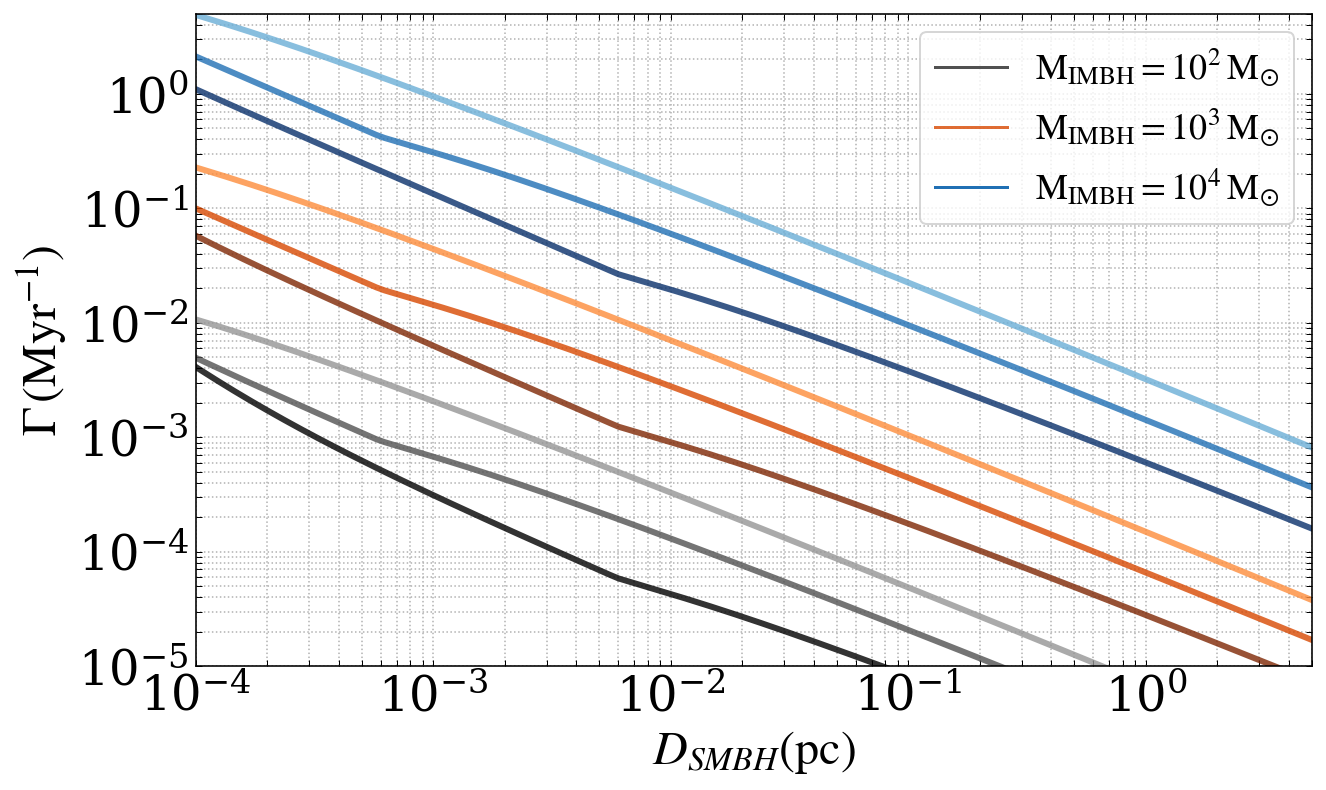

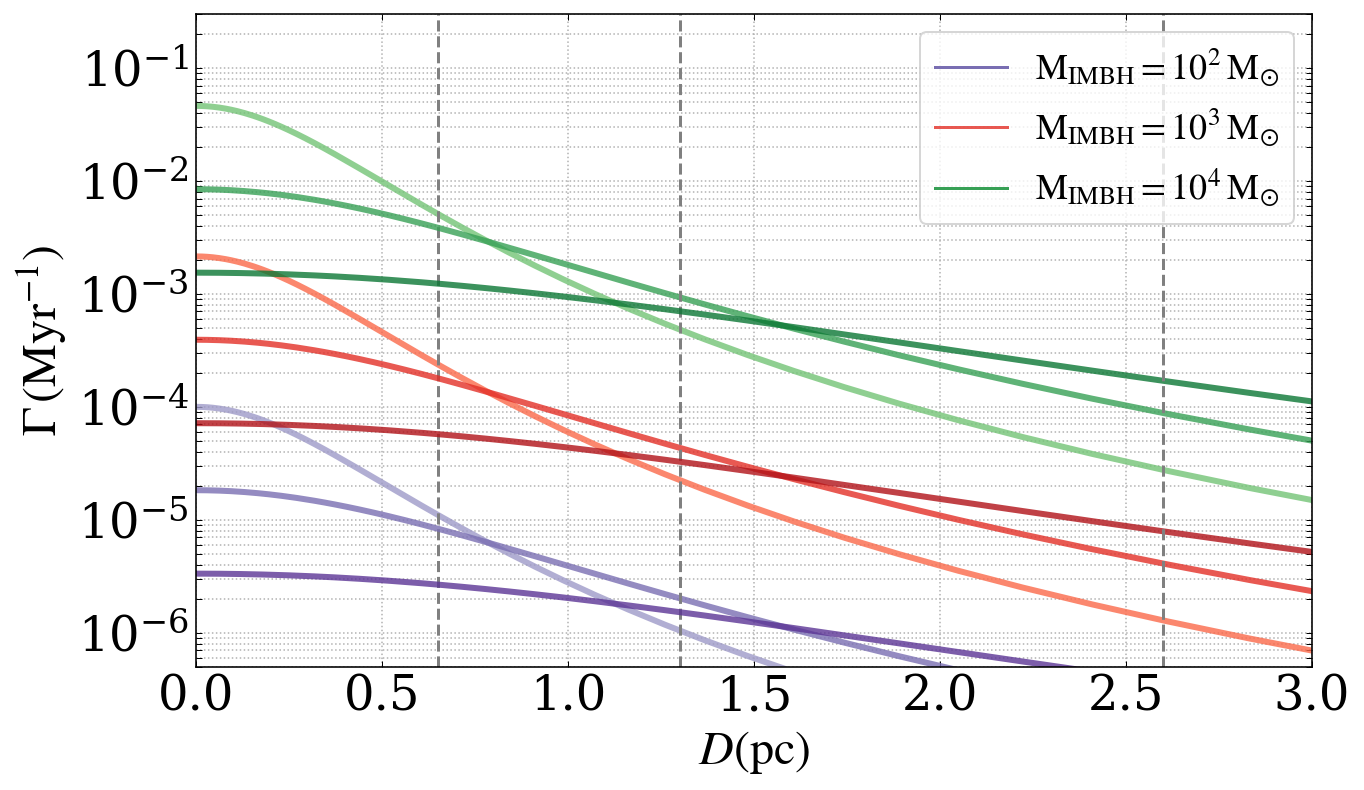

In [26]:
##Capture rate as a function of IMBH mass
M_smbh = [1e5,1e6,1e7]
bparams=[0.5,1,2]
M_plummer = 2e5
M_wd = 0.6; R_wd = R_WD(0.6); n_wd=1.5
M_imbh=[1e2, 1e3, 1e4]
test_range=np.linspace(1,200,100)  ##for pericenter distance in pc
d_array = np.logspace(np.log10(0.00001), np.log10(100), 200) ##for distances to the SMBH in pc


############################################################
##For galactic center
cs = [[],[],[]]
cs[0]=cm.Greys(np.linspace(0.5, 1, 3))
cs[1]=cm.Oranges(np.linspace(0.5, 1, 3))
cs[2]=cm.Blues(np.linspace(0.5, 1, 3))

greyline=mlines.Line2D([], [],  linestyle = '-', color=cs[0][1],
                  label=r'$\rm{M_{IMBH}=10^2}\,M_{\odot}$')
orangeline=mlines.Line2D([], [],  linestyle = '-', color=cs[1][1],
                  alpha=0.8, label=r'$\rm{M_{IMBH}=10^3}\,M_{\odot}$')
blueline=mlines.Line2D([], [],  linestyle = '-', color=cs[2][1],
                  label=r'$\rm{M_{IMBH}=10^4}\,M_{\odot}$')

fig, ax = plt.subplots(figsize=(10,6))
for ii in range(len(M_smbh)):
    for jj in range(len(M_imbh)):
        Gamma_enc = []
        for xx in range(len(d_array)):
            N_wd = N_WD(M_smbh[ii], d_array[xx])  ##pc^-3
        
            vel_disp = Sigma_V(d_array[xx],M_smbh[ii])  ##km/s
            
            E_kin = 0.5*M_imbh[jj]*M_wd/(M_imbh[jj]+M_wd)*vel_disp**2

            f = lambda x: E_oscillate(x*R_wd, M_wd, R_wd, n_wd, M_imbh[jj])- E_kin
            root_range=[]
            root_range2=[]
            for yy in range(len(test_range)-1):
                if f(test_range[yy])>=0 and f(test_range[yy+1])<=0:
                    root_range.append(test_range[yy])
                    root_range.append(test_range[yy+1])
                
                if f(test_range[yy])<=0 and f(test_range[yy+1])>=0:
                    root_range2.append(test_range[yy])
                    root_range2.append(test_range[yy+1])
                
            if len(root_range)>2 or len(root_range2)>2:
                print('more than 1 root')
                              
        #print(E_oscillate(root_range[0]*R_wd, M_wd, R_wd, n_wd, M_imbh[jj])-E_kin)
        #print(E_oscillate(root_range[1]*R_wd, M_wd, R_wd, n_wd, M_imbh[jj])-E_kin)
        #if len(root_range2)>0:
        #    print(E_oscillate(root_range2[0]*R_wd, M_wd, R_wd, n_wd, M_imbh[jj])-E_kin)
        #    print(E_oscillate(root_range2[1]*R_wd, M_wd, R_wd, n_wd, M_imbh[jj])-E_kin)
        
            real_root = bisect(f, root_range[0],root_range[1])
            r_cap=real_root*R_wd/PC_Rsun  ## in pc
            if r_cap < (M_imbh[jj]/M_wd)**(1./3.)*R_wd/PC_Rsun:
                r_cap = (M_imbh[jj]/M_wd)**(1./3.)*R_wd/PC_Rsun
            sigma_cross=Sigma_Cap(r_cap, M_imbh[jj], M_wd, M_smbh[ii], d_array[xx])  ##in pc^2
        
            Gamma_enc.append(N_wd*sigma_cross*vel_disp)  ##Myr^-1
        
        ax.plot(d_array, Gamma_enc, color=cs[jj][ii], lw = 3, alpha=0.8)#,
               #label=r'$M_{SMBH}=%.0e, M_{IMBH}=%e$'%(M_smbh[ii],M_imbh[jj]))

ax.set_xlim(xmin=1e-4,xmax=5)
ax.set_ylim(ymin=1e-5, ymax=5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$D_{SMBH}\rm{(pc)}$')
ax.set_ylabel(r'$\Gamma\,\rm{(Myr^{-1})}$')
ax.legend(handles = [greyline,orangeline,blueline], loc='best', fontsize=18)
plt.grid(linestyle=':',which='major',linewidth='0.75')
plt.grid(linestyle=':',which='minor',linewidth='0.75')
plt.gca().xaxis.set_ticks_position('both')
plt.gca().yaxis.set_ticks_position('both')
plt.tick_params('both',length=3,width=0.5,which='both',direction = 'in')

plt.savefig(savepath+'Enc_rate_Dsmbh.pdf', dpi=300)
############################################################
##For Plummer sphere
cs = [[],[],[]]
cs[0]=cm.Purples(np.linspace(0.5, 1, 4))
cs[1]=cm.Reds(np.linspace(0.5, 1, 4))
cs[2]=cm.Greens(np.linspace(0.5, 1, 4))

greyline=mlines.Line2D([], [],  linestyle = '-', color=cs[0][1],
                  label=r'$\rm{M_{IMBH}=10^2}\,M_{\odot}$')
orangeline=mlines.Line2D([], [],  linestyle = '-', color=cs[1][1],
                  alpha=0.8, label=r'$\rm{M_{IMBH}=10^3}\,M_{\odot}$')
blueline=mlines.Line2D([], [],  linestyle = '-', color=cs[2][1],
                  label=r'$\rm{M_{IMBH}=10^4}\,M_{\odot}$')

fig, ax = plt.subplots(figsize=(10,6))
for ii in range(len(bparams)):
    for jj in range(len(M_imbh)):
        Gamma_enc = []
        for xx in range(len(d_array)):
            N_wd = N_WD_plummer(d_array[xx], 0.20, M_plummer, bparams[ii])  ##pc^-3
        
            vel_disp = plummer_sigma_v(d_array[xx], M_plummer, bparams[ii]) ##km/s
            
            E_kin = 0.5*M_imbh[jj]*M_wd/(M_imbh[jj]+M_wd)*vel_disp**2

            f = lambda x: E_oscillate(x*R_wd, M_wd, R_wd, n_wd, M_imbh[jj])- E_kin
            root_range=[]
            root_range2=[]
            for yy in range(len(test_range)-1):
                if f(test_range[yy])>=0 and f(test_range[yy+1])<=0:
                    root_range.append(test_range[yy])
                    root_range.append(test_range[yy+1])
                
                if f(test_range[yy])<=0 and f(test_range[yy+1])>=0:
                    root_range2.append(test_range[yy])
                    root_range2.append(test_range[yy+1])
                
            if len(root_range)>2 or len(root_range2)>2:
                print('more than 1 root')
                              
        #print(E_oscillate(root_range[0]*R_wd, M_wd, R_wd, n_wd, M_imbh[jj])-E_kin)
        #print(E_oscillate(root_range[1]*R_wd, M_wd, R_wd, n_wd, M_imbh[jj])-E_kin)
        #if len(root_range2)>0:
        #    print(E_oscillate(root_range2[0]*R_wd, M_wd, R_wd, n_wd, M_imbh[jj])-E_kin)
        #    print(E_oscillate(root_range2[1]*R_wd, M_wd, R_wd, n_wd, M_imbh[jj])-E_kin)
        
            real_root = bisect(f, root_range[0],root_range[1])
            r_cap=real_root*R_wd/PC_Rsun  ## in pc
            if r_cap < (M_imbh[jj]/M_wd)**(1./3.)*R_wd/PC_Rsun:
                r_cap = (M_imbh[jj]/M_wd)**(1./3.)*R_wd/PC_Rsun
            sigma_cross=plummer_sigma_cap(r_cap, M_imbh[jj], Mwd, M_plummer, bparams[ii], d_array[xx])  ##in pc^2
        
            Gamma_enc.append(N_wd*sigma_cross*vel_disp)  ##Myr^-1
        
        ax.plot(d_array, Gamma_enc, color=cs[jj][ii], lw = 3, alpha=0.8)#,
               #label=r'$M_{SMBH}=%.0e, M_{IMBH}=%e$'%(M_smbh[ii],M_imbh[jj]))
            
    ax.axvline(x=1.3*bparams[ii], ls='--', color='gray')     

ax.set_ylim(ymin=5e-7, ymax=0.3)
ax.set_xlim(0,3)
#ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$D \rm{(pc)}$')
ax.set_ylabel(r'$\Gamma\,\rm{(Myr^{-1})}$')
ax.legend(handles = [greyline,orangeline,blueline], loc='best', fontsize=18)
plt.grid(linestyle=':',which='major',linewidth='0.75')
plt.grid(linestyle=':',which='minor',linewidth='0.75')
plt.gca().xaxis.set_ticks_position('both')
plt.gca().yaxis.set_ticks_position('both')
plt.tick_params('both',length=3,width=0.5,which='both',direction = 'in')

#plt.savefig(savepath+'Enc_rate_Dclu.pdf', dpi=300)

21594.0546012757
1.184117930600656
13697.312262403799
[97.66455477745542]
173.2234073016961


/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: overflow encountered in double_scalars
/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: overflow encountered in double_scalars
/software/anaconda3.6/lib/python3.6/site-packages/matplotlib/ticker.py:2512: UserWarning: AutoMinorLocator does not work with logarithmic scale
  warnings.warn('AutoMinorLocator does not work with logarithmic '


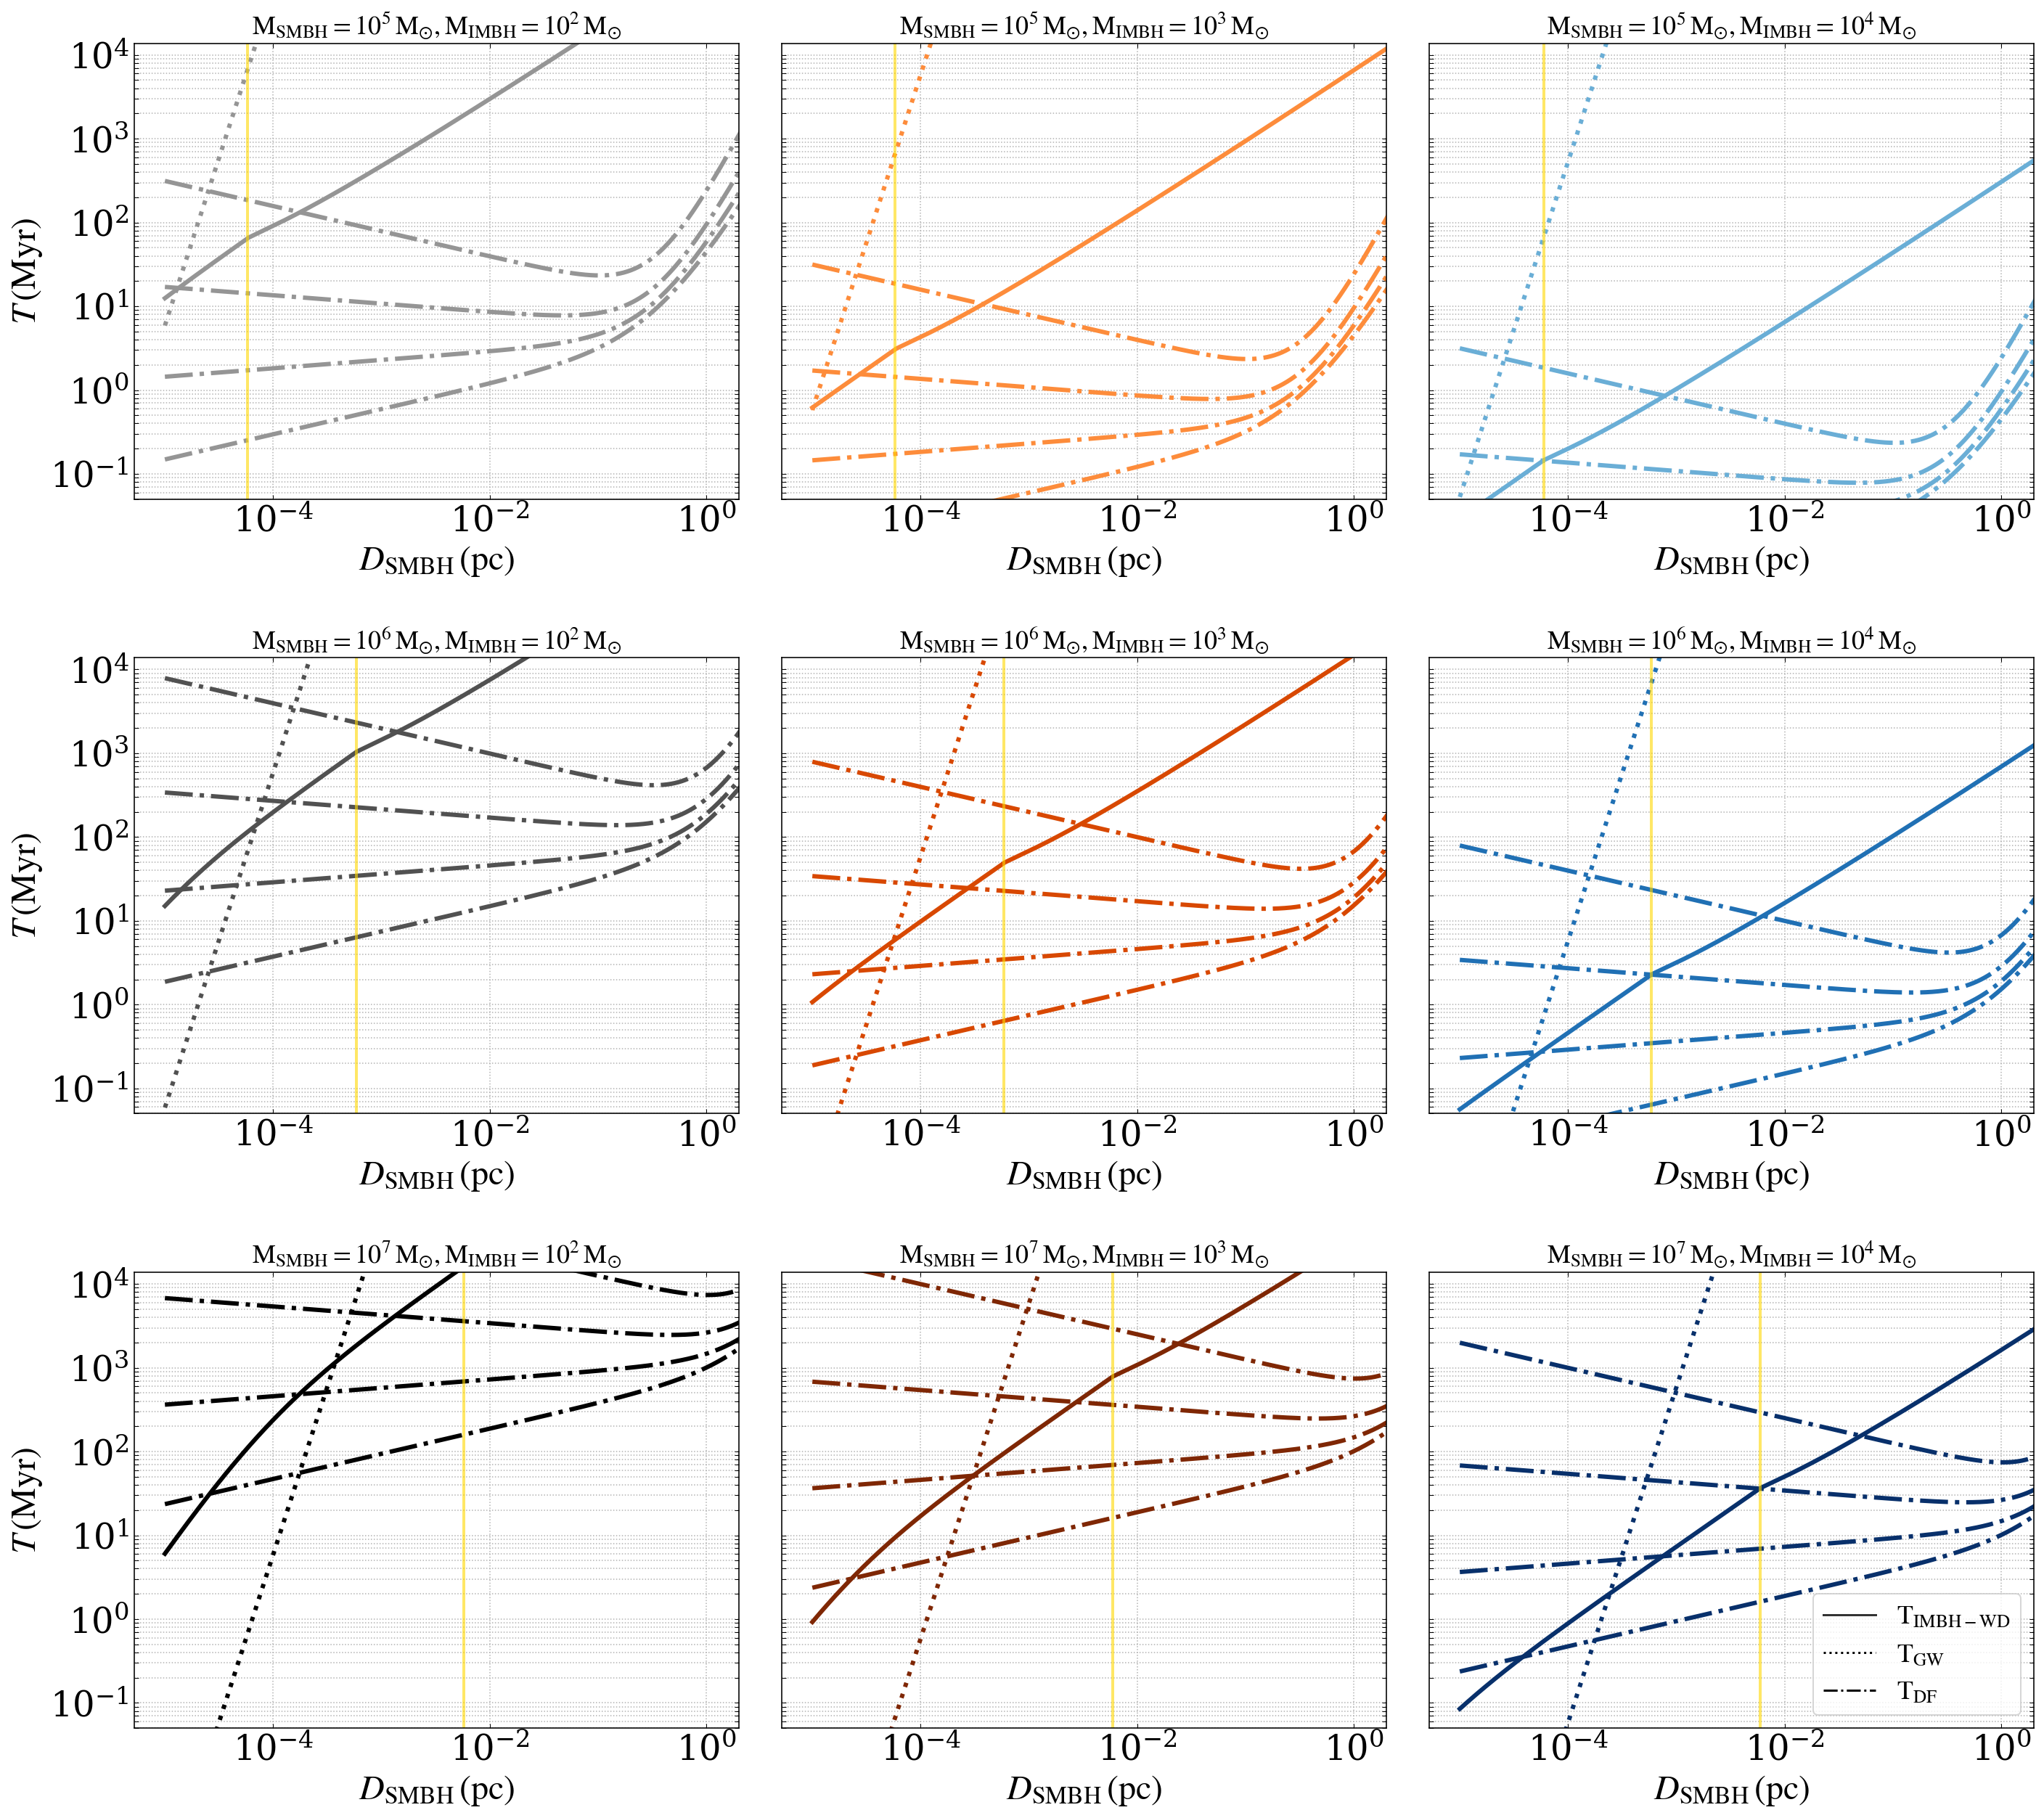

In [17]:
####Comparing time scales
##Other number densities
def N_x(Msmbh, r_pos, startype):
    rinf = Rsmbh(Msmbh)   ##in pc
    ninf_ms = 1.38e5*math.sqrt(1e6/Msmbh)   ##pc^-3
    if startype=='MS':
        alphax = 1.4
        Cx=1
    elif startype=='WD':
        alphax = 1.4
        Cx = 0.1
    elif startype=='NS':
        alphax = 1.5
        Cx = 0.01*(3-alphax)/(3-1.4)
    elif startype=='BH':
        alphax = 2.
        Cx = 0.0023*(3-alphax)/(3-1.4)
        
    n_density = ninf_ms*Cx*pow(r_pos/rinf,-alphax)
    
    return n_density
print(N_x(10**6, 0.86, 'WD'))

def rho_x_tot(Msmbh, r_pos):
    rho_tot = N_x(Msmbh, r_pos, 'MS')*1.#+N_x(Msmbh, r_pos, 'WD')*0.6+N_x(Msmbh, r_pos, 'NS')*1.4+N_x(Msmbh, r_pos, 'BH')*10.
    return rho_tot


##Tidal capture time scale
def Timbhwd(Mimbh, Mwd, Msmbh, r_pos, rcap):  ##in Myr
    nwd = N_WD(Msmbh, r_pos)
    #print(nwd)
    sig_cap = Sigma_Cap(rcap, Mimbh, Mwd, Msmbh, r_pos)  ##rcap needs to be in pc
    sig_v = Sigma_V(r_pos, Msmbh)
    #print(sig_v)
    
    gamma_temp = nwd*sig_cap*sig_v
    t_imbhwd = (1/gamma_temp)*(PC/10.**5)/yearsc/10.**6
    
    return t_imbhwd
    

##GW radiation and IMBH-SMBH inspiral time scale
def Tgw(Mimbh, Msmbh, Mwd, r_pos, eimbh):  ##in Myr
    Qratio = Msmbh/(Mimbh+Mwd)
    t_gw = (5./256.)*((PC/10**5/yearsc/10**6)*clight_km**5/Gconst_sun**3/Mimbh**3/Qratio/(1+Qratio))*r_pos**4*(1-eimbh**2)**(7./2.)
    return t_gw
    

##Dynamical friction timescale
def Tdf_fragione(Msmbh, r_pos, Mimbh, Mwd, gslope):
    ##MS density distribution
    rinf = Rsmbh(Msmbh)   ##in pc
    ninf_ms = 1.38e5*math.sqrt(1e6/Msmbh)   ##pc^-3
    alphax = gslope
    Cx=1
    #n_ms = ninf_ms*Cx*pow(r_pos/rinf,-alphax)
    
    alpha=3-alphax
    B=1.7
    Qratio = Msmbh/(Mimbh+Mwd)
    Th = Gconst_sun*eta**(3./4.)*Msmbh**(1./4.)*(PC/10.**5/yearsc/10.**6)
    #print('Th', Th)
    
    Xc = math.sqrt(2-alpha)
    chi = math.erf(Xc)-2*Xc/math.sqrt(np.pi)*math.exp(-Xc**2)
    #print(chi)
    loglam=5
    
    ##Calculate cusp mass
    #alpha1 = 1.63; alpha2=1.
    #t_df_f = []
    Mr = []
    for xx in range(len(r_pos)):
        #if r_pos[xx]<=0.38:
        #    Mr=1.2e6*integrate.quad(lambda x: 2*twopi*x**2*(x/0.38)**(alpha1-3.), 0, r_pos[xx])[0]
        #    zeta = Mr/Msmbh
        #    t_df_f.append((1+(alpha1+1)/2.*zeta)*(1+zeta)**0.5*Qratio*Th*(r_pos[xx]/rinf)**(3./2.)/(1.5*chi*loglam*alpha1*zeta))
        #else:
        #    Mr=1.2e6*integrate.quad(lambda x: 2*twopi*x**2*(x/0.38)**(alpha1-3.), 0, 0.38)[0]+\
        #              1.2e6*integrate.quad(lambda x: 2*twopi*x**2*(x/0.38)**(alpha2-3.), 0.38, r_pos[xx])[0]
        #    zeta = Mr/Msmbh
        #    t_df_f.append(0.75*Msmbh**(1./2.)*Qratio*(1+zeta)**(3./2.)*Th*(r_pos[xx]/rinf)**(1./2.)/(chi*loglam*2.18e6*Gconst_sun*eta**(1./2.)))
        Mr.append(integrate.quad(lambda x: 2*twopi*x**2*(ninf_ms*Cx*pow(x/rinf,-alphax)), 0, r_pos[xx])[0])
    zeta = np.array(Mr)/Msmbh
    
    #t_df_f = (1+(4-alpha)/(6-alpha)*zeta)*(1+zeta)**0.5*Qratio*Th/((3-alpha)*B*zeta)*(r_pos/rinf)**(3./2.)
    
    #t_df_f = (1+(alpha+1)/2.*zeta)*(1+zeta)**0.5*Qratio*Th*(r_pos/rinf)**(3./2.)/(1.5*chi*loglam*alpha*zeta)
    t_df_f = Qratio*(1+(alpha+1)/2*(r_pos/rinf)**alpha)*(1+(r_pos/rinf)**alpha)**0.5*(r_pos/rinf)**1.5/(1.5*chi*loglam*alpha*(r_pos/rinf)**alpha)*Th
    #print('factor', 1.5*chi*loglam*alpha)
    
    return t_df_f
    
#print('tdf_f', Tdf_fragione(4e6, np.array([0.1]), 20000, 0.6))   

###################################################################
##Not using these
##from Rasskazov & Kocsis 2019 eq. 18a
def Tdf(Mimbh, Msmbh, r_pos, gamma1=1.5, gamma2=3.2): ##in Myr
    loglambda = math.log(Msmbh/Mimbh)
    #print(loglambda)
    
    t_df0_rl = (3*Rsmbh(Msmbh))**1.5*Msmbh**0.5/(1.08*(3-gamma1)*loglambda*Gconst_sun**0.5*Mimbh)
    t_df0_rl = t_df0_rl*(PC/10.**5)/yearsc/10.**6
    
    t_df0_rs = Rsmbh(Msmbh)**1.5*Msmbh**0.5/(1.08*(3-gamma1)*loglambda*Gconst_sun**0.5*Mimbh)
    t_df0_rs = t_df0_rs*(PC/10.**5)/yearsc/10.**6
    
    #print(t_df0_rl, t_df0_rs)
    
    t_df = []
    
    for xx in range(len(r_pos)):
        if r_pos[xx]/Rsmbh(Msmbh)>1:
            tdf_temp = t_df0_rl* \
            (r_pos[xx]/Rsmbh(Msmbh))**(gamma2-1.5)* \
            (1+(2./3.)*((3.-gamma1)/(gamma2-3.))*(1-(r_pos[xx]/Rsmbh(Msmbh))**(3-gamma2)))**1.5
            
            t_df.append(tdf_temp)
        else:
            tdf_temp = t_df0_rs* \
            (r_pos[xx]/Rsmbh(Msmbh))**(gamma1-1.5)* \
            (1+2.*(r_pos[xx]/Rsmbh(Msmbh))**(3-gamma1))**1.5
            
            t_df.append(tdf_temp)
    
    return t_df


##Dymical friction timescale Gurkan & Rasio 2005
def Tdf_gurkan(Msmbh, r_pos, Mimbh, Mwd):
    Rb = 0.38 ##pc
    A1 = 2.46e6; A2 = 2.18e6 ##Msun
    alpha1 = 1.63; alpha2=1.; alpha=1.6
    Xc = math.sqrt(2-alpha)
    chi = math.erf(Xc)-2*Xc/math.sqrt(np.pi)*math.exp(-Xc**2)
    print('chi',chi)
    loglam = 5.
    
    t_df_g = []
    for xx in range(len(r_pos)):
        R0 = r_pos[xx] ##pc
        if r_pos[xx]<Rb:
            t_df_g.append(integrate.quad(lambda x: (Msmbh+A1*(alpha1+1.)/2.*x**alpha1)*(Msmbh+A1*x**alpha1)**(1./2.)/x**(alpha1-1./2.)/(chi*loglam*Gconst_pc**(1./2.)*A1*alpha1*(Mimbh+Mwd)), 0.000000001, r_pos[xx])[0]/(yearsc*10.**6))
            #print('small', integrate.quad(lambda x: (Msmbh+A1*(alpha1+1.)/2.*x**alpha1)*(Msmbh+A1*x**alpha1)**(1./2.)/x**(alpha1-1./2.)/(chi*loglam*Gconst_sun**(1./2.)*A1*alpha1*(Mimbh+Mwd)), 0.00001, r_pos[xx])[0])
        else:
            M2 = A2*R0
            C1 = Msmbh+A1*Rb**alpha1-A2*Rb+M2
            C2 = 2*twopi*chi*loglam*M2*(Mimbh+Mwd)
            C3 = C2/C1**(1./2.)
            T0 = twopi*(R0**3/Gconst_sun/C1)**(1./2.)*(PC/1e5)/(yearsc*1e6)
            t_df_g.append(integrate.quad(lambda x: (C1-M2+M2*x)**(3./2.)/x**(1./2.)/C3, 0, 1.)[0]*T0)
            #print('large', integrate.quad(lambda x: (C1-M2+M2*x)**(3./2.)/x**(1./2.)/(-C3), 1., 0.)[0])
            #print('large T0', T0)
        #C1=chi*loglam*(Gconst_mkgs)**(1./2.)*A1*alpha1*(Mimbh+Mwd)
        #tdfg = integrate.quad(lambda x: (Msmbh+A1*x**alpha1*(alpha1+1)/2.)*(Msmbh+A1*x**alpha1)**(1./2.)/x**(alpha1-1./2.)/C1, 0., R0*(PC/10**2))[0]
        #t_df_g.append(tdfg/yearsc/10**6)
        
    print(t_df_g)
    return t_df_g
############################################################

##Plotting
#d_array = np.linspace(0.00001, 5, 500) ##for distances to the SMBH in pc
d_array = np.logspace(np.log10(0.00001), np.log10(5), 500) ##for distances to the SMBH in pc
M_smbh = [1e5, 1e6,1e7]
M_wd = 0.6; R_wd = R_WD(0.6); n_wd=1.5
M_imbh=[1e2, 1e3, 1e4]
Msmbh_label = ['10^5', '10^6', '10^7']
Mimbh_label = ['10^2', '10^3', '10^4']
print(Rsmbh(M_smbh[1]))
#print(((3*0.86)**1.5)*10**3/(1.08*1.5*6.9*(4.3*10**-3)**0.5*1000.))
#print((PC/10.**5)/yearsc/10**6)
print(Timbhwd(M_imbh[1],M_wd,M_smbh[1],0.86,30*R_wd/PC_Rsun))
print(Tdf(1000, 4e6, [3.14]))
print(np.sqrt(Gconst_sun*3.*4e6/1.72))

############################################################
test_range=np.linspace(1,200,100)  ##for pericenter distance in WD radius
##Calculate capture cross sections for galactic center
Rcap_smbh = [[],[],[]]
for ii in range(len(M_smbh)):
    for jj in range(len(M_imbh)):
        r_cap=[]
        for xx in range(len(d_array)):
            vel_disp = Sigma_V(d_array[xx],M_smbh[ii])
            E_kin = 0.5*M_imbh[jj]*M_wd/(M_imbh[jj]+M_wd)*vel_disp**2
            f = lambda x: E_oscillate(x*R_wd, M_wd, R_wd, n_wd, M_imbh[jj])- E_kin
            
            root_range=[]
            root_range2=[]
            for yy in range(len(test_range)-1):
                if f(test_range[yy])>=0 and f(test_range[yy+1])<=0:
                    root_range.append(test_range[yy])
                    root_range.append(test_range[yy+1])
                    
                if f(test_range[yy])<=0 and f(test_range[yy+1])>=0:
                    root_range2.append(test_range[yy])
                    root_range2.append(test_range[yy+1])
                    
            if len(root_range)>2 or len(root_range2)>2:
                print('more than 1 root')
            
            real_root = bisect(f, root_range[0],root_range[1])
            if real_root<(M_imbh[jj]/M_wd)**(1./3.):
                real_root = (M_imbh[jj]/M_wd)**(1./3.)
            r_cap.append(real_root)
            
        Rcap_smbh[ii].append(r_cap)
        
#print(Rcap_smbh[1][1])
############################################################

cs = [[],[],[]]
cs[0]=cm.Greys(np.linspace(0.5, 1, 3))
cs[1]=cm.Oranges(np.linspace(0.5, 1, 3))
cs[2]=cm.Blues(np.linspace(0.5, 1, 3))
dotline=mlines.Line2D([], [],  linestyle = 'dotted', color='k',
                  label=r'$\rm{T_{GW}}$')
solidline=mlines.Line2D([], [],  linestyle = '-', color='k',
                  alpha=0.8, label=r'$\rm{T_{IMBH-WD}}$')
dashdotline=mlines.Line2D([], [],  linestyle = 'dashdot', color='k',
                  label=r'$\rm{T_{DF}}$')
fig, ax = plt.subplots(ncols=3, nrows=3, sharey = True, figsize=(20, 18))
for ii in range(len(M_smbh)):
#    print(Rsmbh(M_smbh[ii]))
    for jj in range(len(M_imbh)):
        ax[ii][jj].plot(d_array, Tgw(M_imbh[jj],M_smbh[ii],M_wd,d_array,0),
               lw=3., ls='dotted', color=cs[jj][ii])
        ax[ii][jj].plot(d_array, Timbhwd(M_imbh[jj],M_wd,M_smbh[ii],d_array, 
                                                  np.array(Rcap_smbh[ii][jj])*R_wd/PC_Rsun),
               lw=3., color=cs[jj][ii])
        ax[ii][jj].plot(d_array, Tdf_fragione(M_smbh[ii], np.array(d_array), M_imbh[jj], M_wd, 1.8),
               lw=3., ls = 'dashdot', color=cs[jj][ii])
        ax[ii][jj].plot(d_array, Tdf_fragione(M_smbh[ii], np.array(d_array), M_imbh[jj], M_wd, 1.6),
               lw=3., ls = 'dashdot', color=cs[jj][ii])
        ax[ii][jj].plot(d_array, Tdf_fragione(M_smbh[ii], np.array(d_array), M_imbh[jj], M_wd, 1.4),
               lw=3., ls = 'dashdot', color=cs[jj][ii])
        ax[ii][jj].plot(d_array, Tdf_fragione(M_smbh[ii], np.array(d_array), M_imbh[jj], M_wd, 1.2),
               lw=3., ls = 'dashdot', color=cs[jj][ii])
        #ax[ii][jj].plot(d_array/Rsmbh(M_smbh[ii]), Tdf_gurkan(M_smbh[ii], np.array(d_array), M_imbh[jj], M_wd),
        #       lw=3., ls = 'dotted', color=cs[jj][ii], label='Tdf_g')
        #ax[ii][jj].plot(d_array/Rsmbh(M_smbh[ii]), Tdf(M_imbh[jj],M_smbh[ii],d_array),
        #       lw=3., ls = '--', color=cs[jj][ii], label='Tdf')
        ax[ii][jj].set_title(r'$\rm{M_{SMBH}}=%s\,\rm{M_{\odot}}, \rm{M_{IMBH}}=%s\,\rm{M_{\odot}}$'%(Msmbh_label[ii],Mimbh_label[jj]), fontsize=18)

        #ax[ii][jj].axhline(y=13800., ls='--', color='k', lw=2.)
        ax[ii][jj].axvline(x=cap_tde_tran[ii][jj], color = 'gold', lw=2, alpha=0.6)
        #ax[ii][jj].axvline(x=Rsmbh(M_smbh[ii]), color = 'darkturquoise', lw=2, alpha=0.6)
                
        ax[ii][jj].set_xscale('log')
        ax[ii][jj].set_yscale('log')
        ax[ii][jj].set_ylim(ymin=5e-2, ymax=13800.)
        ax[ii][jj].set_xlim(xmax=2)
        ax[ii][jj].set_xlabel(r'$D_{\rm{SMBH}}\,(\rm{pc})$')
        ax[ii][0].set_ylabel(r'$T\,(\rm{Myr})$')
        
        ax[ii][jj].xaxis.set_minor_locator(AutoMinorLocator())
        ax[ii][jj].grid(linestyle=':',which='major',linewidth='0.75')
        ax[ii][jj].grid(linestyle=':',which='minor',linewidth='0.75')
        ax[ii][jj].xaxis.set_ticks_position('both')
        ax[ii][jj].yaxis.set_ticks_position('both')
        ax[ii][jj].tick_params('both',length=3,width=0.5,which='both',direction = 'in')
        

ax[2][2].legend(handles=[solidline,dotline,dashdotline],fontsize=18)
fig.tight_layout()

plt.savefig(savepath+'timescale.pdf', dpi=300)


##Find the mass range where Timbhwd < min(Tdf, Tgw)
#M_smbh_array = np.linspace(1e5, 1e7, 20)
#M_imbh_array = np.linspace(100., 1e5, 20)
#M_smbh_work = []
#M_imbh_work = []
#d_work = []
#
#test_range=np.linspace(1,200,100)  ##for pericenter distance in WD radius
#Rcap_smbh_array = [[] for _ in range(len(M_smbh_array))]
#
#for ii in range(len(M_smbh_array)):
#    for jj in range(len(M_imbh_array)):
#        rcap=[]
#        for cc in range(len(d_array)):
#            vel_disp = Sigma_V(d_array[cc],M_smbh_array[ii])
#            E_kin = 0.5*M_imbh_array[jj]*M_wd/(M_imbh_array[jj]+M_wd)*vel_disp**2
#            f = lambda x: E_oscillate(x*R_wd, M_wd, R_wd, n_wd, M_imbh_array[jj])- E_kin
#            
#            root_range=[]
#            root_range2=[]
#            for yy in range(len(test_range)-1):
#                if f(test_range[yy])>=0 and f(test_range[yy+1])<=0:
#                    root_range.append(test_range[yy])
#                    root_range.append(test_range[yy+1])
#                    
#                if f(test_range[yy])<=0 and f(test_range[yy+1])>=0:
#                    root_range2.append(test_range[yy])
#                    root_range2.append(test_range[yy+1])
#                    
#            if len(root_range)>2 or len(root_range2)>2:
#                print('more than 1 root')
#            
#            real_root = bisect(f, root_range[0],root_range[1])
#            rcap.append(real_root)
#            
#          
#        Rcap_smbh_array[ii].append(rcap)
#        
#        t_gw = Tgw(M_imbh_array[jj],M_smbh_array[ii],M_wd,d_array,0)
#        t_df = Tdf(M_imbh_array[jj],M_smbh_array[ii],d_array)
#        t_cap = Timbhwd(M_imbh_array[jj],M_wd,M_smbh_array[ii],d_array,np.array(Rcap_smbh_array[ii][jj])*R_wd/PC_Rsun)
#        #print(t_cap)
#        for xx in range(len(d_array)):
#            if t_cap[xx] < min(t_gw[xx], t_df[xx]):
#                M_smbh_work.append(M_smbh_array[ii])
#                M_imbh_work.append(M_imbh_array[jj])
#                d_work.append(d_array[xx])
#                
#print(M_smbh_work, M_imbh_work, d_work)

LISA_max 2.0708878540829736
d = 0.01 0.6 100 rTDE = 0.07032261451906822 Radius =  0.012778467098439529 a0 = 0.06543480796777966 0.99 fGW = 0.03067303893471015
0 0.6 100 0.012778467098439529 0.00032717403983889863 0.0016666043345619009
reached TDE! 100 0.00038976452784799043 0.14499551076992948 24.21287023752535
inspiral time until TDE 1665.3216248757967
d = 0.01 4.18153035492267e-17 SNR =  14.48208085291201
d = 0.01 0.6 100 rTDE = 0.07032261451906822 Radius =  0.012778467098439529 a0 = 1.0 0.01 fGW = 6.408134505732992e-07
0 0.6 100 0.012778467098439529 0.00032717403983889863 53222862.08302858
reached TDE! 100 0.00033874164664146557 2.471105263307687e-09 19.61759201646499
inspiral time until TDE 53222862083027.8
d = 0.01 2.4806738837455528e-17 SNR =  1.5437384901672145e-09
d = 0.01 0.6 1000 rTDE = 0.15150548021362037 Radius =  0.012778467098439529 a0 = 0.14097502022135922 0.99 fGW = 0.030590604898114444
1 0.6 1000 0.012778467098439529 0.0007048751011067966 0.00036094724171843533
reached

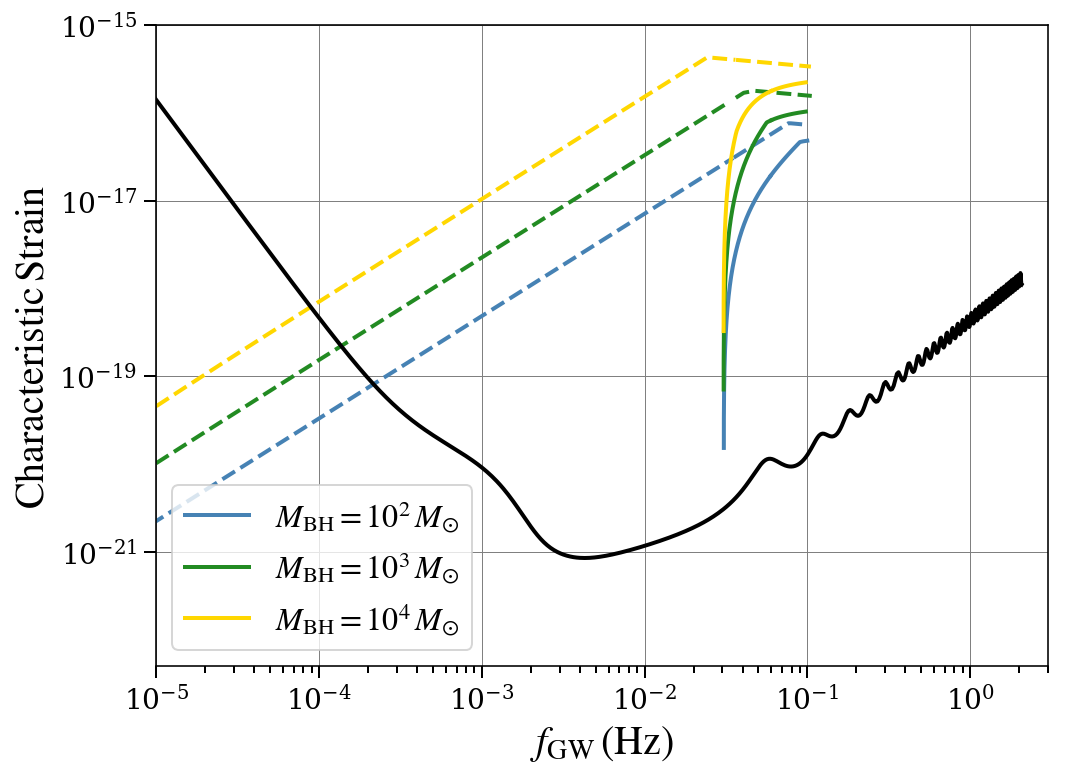

In [10]:
##Plot GW strain of IMBH-WD inspiral
sys.path.insert(1, '/projects/b1095/syr904/MyCodes/PythonCodes/GW_strain')
import ecc_calc as LISA2
import LISA_calculations2 as LISA
import LISA_calculations as LISA_original
import scipy.constants as ct
from scipy.interpolate import interp1d
#from importlib import reload
#reload(LISA2)

G = 6.67e-11
Msun = 1.99e30
M_sun = Msun
AU = 1.5e11
c = 3.0e8

#factor = np.sqrt(32./5.)
factor = 1.0

def get_roche_r(q,a,e):
    R = a*(1-e)*0.49*q**(2./3.) / (0.6*q**(2./3.) + np.log(1+q**(1./3.)))
    return R

def calc_fGW(m1,m2,a,e,z=0):  ##redshifted frequency
    return np.sqrt(G*Msun*(m1+m2))/np.pi*(1+e)**1.1954/(a*AU*(1-e**2.))**1.5/(1.+z)

def find_n_peak(m1,m2,a,e):  ##Non-redshifted n peak
    Porb = np.sqrt(4*np.pi**2/(G*Msun*(m1+m2))*(a*AU)**3.)
    forb = 1./Porb
    fGW = calc_fGW(m1,m2,a,e,z=0)
    n_peak = fGW/forb
    #n_peak = int(fGW/forb)
    return n_peak

def DECIGO_S(f):
    fp = 7.36 #Hz
    Sh = 7.05*10**(-48)*(1.+(f/fp)**2) + 4.8*10**(-51)* f**(-4)/(1.+(f/fp)**2) + 5.33*10**(-52)*f**(-4)
    return np.sqrt(Sh*f)

f_dec = np.logspace(-3,1,1000)
h_dec = DECIGO_S(f_dec)

data = np.genfromtxt('/projects/b1095/syr904/MyCodes/PythonCodes/GW_strain/binaries.dat')

data2 = np.genfromtxt('/projects/b1095/syr904/MyCodes/PythonCodes/GW_strain/characteristic_noise_strain.dat')
fn = data2[:,0]
hn_lisa = data2[:,1]
print('LISA_max', fn[-1])

data3 = np.genfromtxt('/projects/b1095/syr904/MyCodes/PythonCodes/GW_strain/LIGO_sensitivity_curve.dat')

#3173.05782808 14.0 14.0 25.244361 25.34543 1.1271514 0.95188347 273577.0 648641.0 23.0 5133.58511343 3.0

f_GW_array = []
strain_array = []
count = 0
noise_interp = interp1d(fn, hn_lisa, bounds_error=False, fill_value=1e60)
T_OBS = 4


d_arr = [10,800,16000,1000000]  ##kpc
#d_label = [r'$10\,\rm{kpc}$',r'$800\,\rm{kpc}$',r'$16\,\rm{Mpc}$',r'$1\,\rm{Gpc}$']
d_label = [r'$M_{\rm{BH}}=10^2\,M_{\odot}$',r'$M_{\rm{BH}}=10^3\,M_{\odot}$',r'$M_{\rm{BH}}=10^4\,M_{\odot}$']
mBH_arr = [100,1000,10000]
r_tc_fac = [3.03, 3.37, 3.69]
color_array = ['steelblue','forestgreen','gold']

fig, ax1 = plt.subplots(figsize=(8,6)) # strain
#ax2 = plt.subplot(212) # t_insp

for i in range(len(mBH_arr)):
    for k in range(0,2):
        color = color_array[i]
        label = d_label[i]

        #0.0 14.0 0.001 25.0 1.0 0.7 2 0.1
        f_GW_array = []
        strain_array = []
        strain_array_0 = []

        f_GW_array_RL = []
        strain_array_RL = []

        #d = data[i,8]
        d = 10./1000. #Mpc
        z = LISA.zAtLuminosityDistance(d)
        m1 = 0.6 # Mstar
        #m2 = 1000.0 # Mbh
        m2 = mBH_arr[i]
        #a0 = 0.02
        Radius = R_WD(m1) #stellar radius in solar radii
        r_TDE = (m2/m1)**(1./3.)*Radius

        if k ==0:
            e0 = 0.99
            a0 = 2.*r_TDE/(1-e0)/AU_Rsun # initial SMA in AU
            q = m1/m2
            fGW = calc_fGW(m1,m2,a0,e0,z=z)
            LINESTYLE = '-'
        if k == 1:
            e0 = 0.01
            a0 = 1.0
            q = m1/m2
            #print 'CHECK', np.sqrt(G*Msun*(m1+m2))/np.pi/(a0*AU)**1.5
            fGW = calc_fGW(m1,m2,a0,e0,z=z)
            LINESTYLE = '--'
        print('d =', d, m1, m2, 'rTDE =', r_TDE, 'Radius = ', Radius, 'a0 =', a0, e0, 'fGW =',fGW)
        if fGW > 5:
            continue

        t, a, e = LISA.t_inspiral_2(a0,e0,m1,m2,t_flag=0,array=1,LIGO=2)  ##in years

        t_insp = LISA.t_inspiral_2(a0,e0,m1,m2)/1.e6 # In Myr

        delta = 1
                
        LIGO_limit = 5.*2.*G/c**2.*(m1+m2)*Msun
        # Inspiral limit is 5 times sum of schwarschild radii

        r_TD = r_TDE/AU_Rsun # TD radius in AU

        print(i,m1, m2, Radius, r_TD, t_insp)
        RL_flag = 0

        for j in range(0,len(t),delta):
            a_temp = a[j]
            e_temp = e[j]

            #if a_temp*AU*(1-e_temp) > LIGO_limit:
            fGW = calc_fGW(m1,m2,a_temp,e_temp,z=z)

            r_peri = a_temp*(1-e_temp)
            RL = get_roche_r(q,a_temp,0)
            #print Radius, r_peri, r_TD
            #print a_temp, e_temp, r_peri, RL, r_TD
            if r_peri > r_TDE/AU_Rsun:
                n_peak = find_n_peak(m1,m2,a_temp, e_temp)
                #print('npeak', n_peak)
                #strain = LISA.hn(m1,m2,a_temp, e_temp, d, n_peak)
                #############
                m1_geo = m1*M_sun*ct.G/ct.c**2.
                m2_geo = m2*M_sun*ct.G/ct.c**2.
                a_geo = a[j]*AU
                f_orb_geo = np.sqrt((m1_geo+m2_geo)/(4.*np.pi**2.*a_geo**3.))
                #print(ct.G, ct.c, f_orb_geo)

                strain = LISA2.hcn_func(m1_geo, m2_geo, z, n_peak, n_peak*f_orb_geo, e_temp)
                ### Find stationary strain and choose minumum
                Porb = (4.*np.pi**2./(G*Msun*(m1+m2))*(a_temp*AU)**3.)**0.5
                f_orb = 1./Porb
                Tobs = T_OBS*yearsc
                strain_0 = strain*np.sqrt(LISA_original.fdotn_2(m1,m2,Porb,e_temp,n_peak,z)*Tobs/fGW)
                if RL > Radius/AU_Rsun:     # cut off when r_peri is less than r_TD
                    strain_array.append(factor*np.min([strain,strain_0]))
                    f_GW_array.append(fGW)
                    a_RL = a_temp
                    e_RL = e_temp
                else: #star is filling RL                               
                    strain_array_RL.append(factor*np.min([strain,strain_0]))
                    f_GW_array_RL.append(fGW)
                #################

            else:
                a_temp = a[j-1]
                e_temp = e[j-1]
                print('reached TDE!',m2, a_temp, e_temp, 24.*60.*60.*uc.au_to_period(a_temp, m1, m2))
                break

            #######
        
        t=np.array(t); e = np.array(e)
        print('inspiral time until TDE', t[e<=e_temp][0])

        #m1 = m1*Msun
        #m2 = m2*Msun
        SNR = LISA2.snr(m1, m2, a0*AU, e0, d, 100, noise_interp, T_OBS)
        #SNR_RL = LISA2.snr(m1, m2, a_RL*1.5e11, e_RL, d_arr[i]/1000., 50, noise_interp, T_OBS)
        #SNR_stationary = LISA.SNR_calculator(m1,m2,a_RL,e_RL,d_arr[i]/1000.)
        forb = calc_fGW(m1/Msun,m2/Msun,a_RL,e_RL,z=0)
        #Mc = pow(m2*m1,3./5.)/pow(m2+m1,1./5.)
        #h_o = G/pow(c,2.) * Mc/(d*1e6*3.086e16) * pow(G/pow(c,3.)*np.pi*forb*Mc,2./3.)
        #h_f = np.interp(forb, fn, hn_lisa)
        #SNR2 =  h_o*np.sqrt(T_OBS*3.15e7*forb)/h_f

        print('d =', d, forb, 'SNR = ',SNR)
        if k == 0:
            ax1.plot(f_GW_array,strain_array, color=color,lw=2,alpha=1,ls=LINESTYLE,label=label)
            ax1.plot(f_GW_array_RL,strain_array_RL, color=color,lw=2,ls=LINESTYLE,alpha=1)
        if k ==1:
            ax1.plot(f_GW_array,strain_array, color=color,lw=2,alpha=1,ls=LINESTYLE)
            ax1.plot(f_GW_array_RL,strain_array_RL, color=color,lw=2,ls=LINESTYLE,alpha=1)


ax1.plot(data2[:,0], data2[:,1],color='black',lw=2)
#ax1.plot(f_dec, h_dec,color='darkgray',lw=2,ls='-')
#ax1.plot(data3[:,0], data3[:,5],color='gray',lw=3)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(1e-5,3)
ax1.set_ylim(5e-23,1e-15)
#ax1.set_ylim(5e-26,1e-15)
ax1.set_xlabel(r'$f_{\rm{GW}}\,(\rm{Hz})$',fontsize=20)
ax1.set_ylabel(r'$\rm{Characteristic\,Strain}$',fontsize=20)
#plt.setp(ax1.get_xticklabels(), visible=False)
plt.grid(lw=0.5,color='gray',ls='-',zorder=0)

ax1.legend(loc=3,frameon=True, prop={'size': 16},scatterpoints=1)

ax1.xaxis.set_tick_params(width=1,length=6,which='major')
ax1.xaxis.set_tick_params(width=1,length=3.5,which='minor')
ax1.yaxis.set_tick_params(width=1,length=6, which='major')
ax1.yaxis.set_tick_params(width=1,length=3.5, which='minor')

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)

plt.subplots_adjust(wspace=0, hspace=0.02)
plt.tight_layout()
#plt.savefig(savepath+'IMBHWD_gwstrain.pdf', dpi=300)

In [8]:
##Calculate the maximum distance LISA can see
mBH_arr = [100,1000,10000]
SNR_limit=[2.,5.,10.]
T_OBS = 4.
    
for ii in range(len(mBH_arr)):
    for jj in range(len(SNR_limit)):
        m1 = 0.6 # Mstar
        m2 = mBH_arr[ii]
        Radius = R_WD(m1)
        r_TDE = (m2/m1)**(1./3.)*Radius
    
        e0 = 0.99
        a0 = 2.*r_TDE/(1-e0)/AU_Rsun # initial SMA in AU
        n_max = 5*(1+e0)**0.5/(1-e0)**1.5
        print(n_max)
        
        print(LISA2.snr(m1, m2, a0*AU, e0, 1, n_max, noise_interp, T_OBS))
        f = lambda x: LISA2.snr(m1, m2, a0*AU, e0, x, n_max, noise_interp, T_OBS)- SNR_limit[jj]
            
        real_root = bisect(f, 0.01, 500)

        print(mBH_arr[ii], SNR_limit[jj], real_root)

7053.367989832933
8.962376007007519
100 2.0 4.487487662184604
7053.367989832933
8.962376007007519
100 5.0 1.7930483841325937
7053.367989832933
8.962376007007519
100 10.0 0.8962000858469451
7053.367989832933
41.85991064700724
1000 2.0 21.09912588171101
7053.367989832933
41.85991064700724
1000 5.0 8.396920131482698
7053.367989832933
41.85991064700724
1000 10.0 4.191373256901494
7053.367989832933
199.45274301906204
10000 2.0 103.81397387885544
7053.367989832933
199.45274301906204
10000 5.0 40.523274695800986
7053.367989832933
199.45274301906204
10000 10.0 20.098485636194376


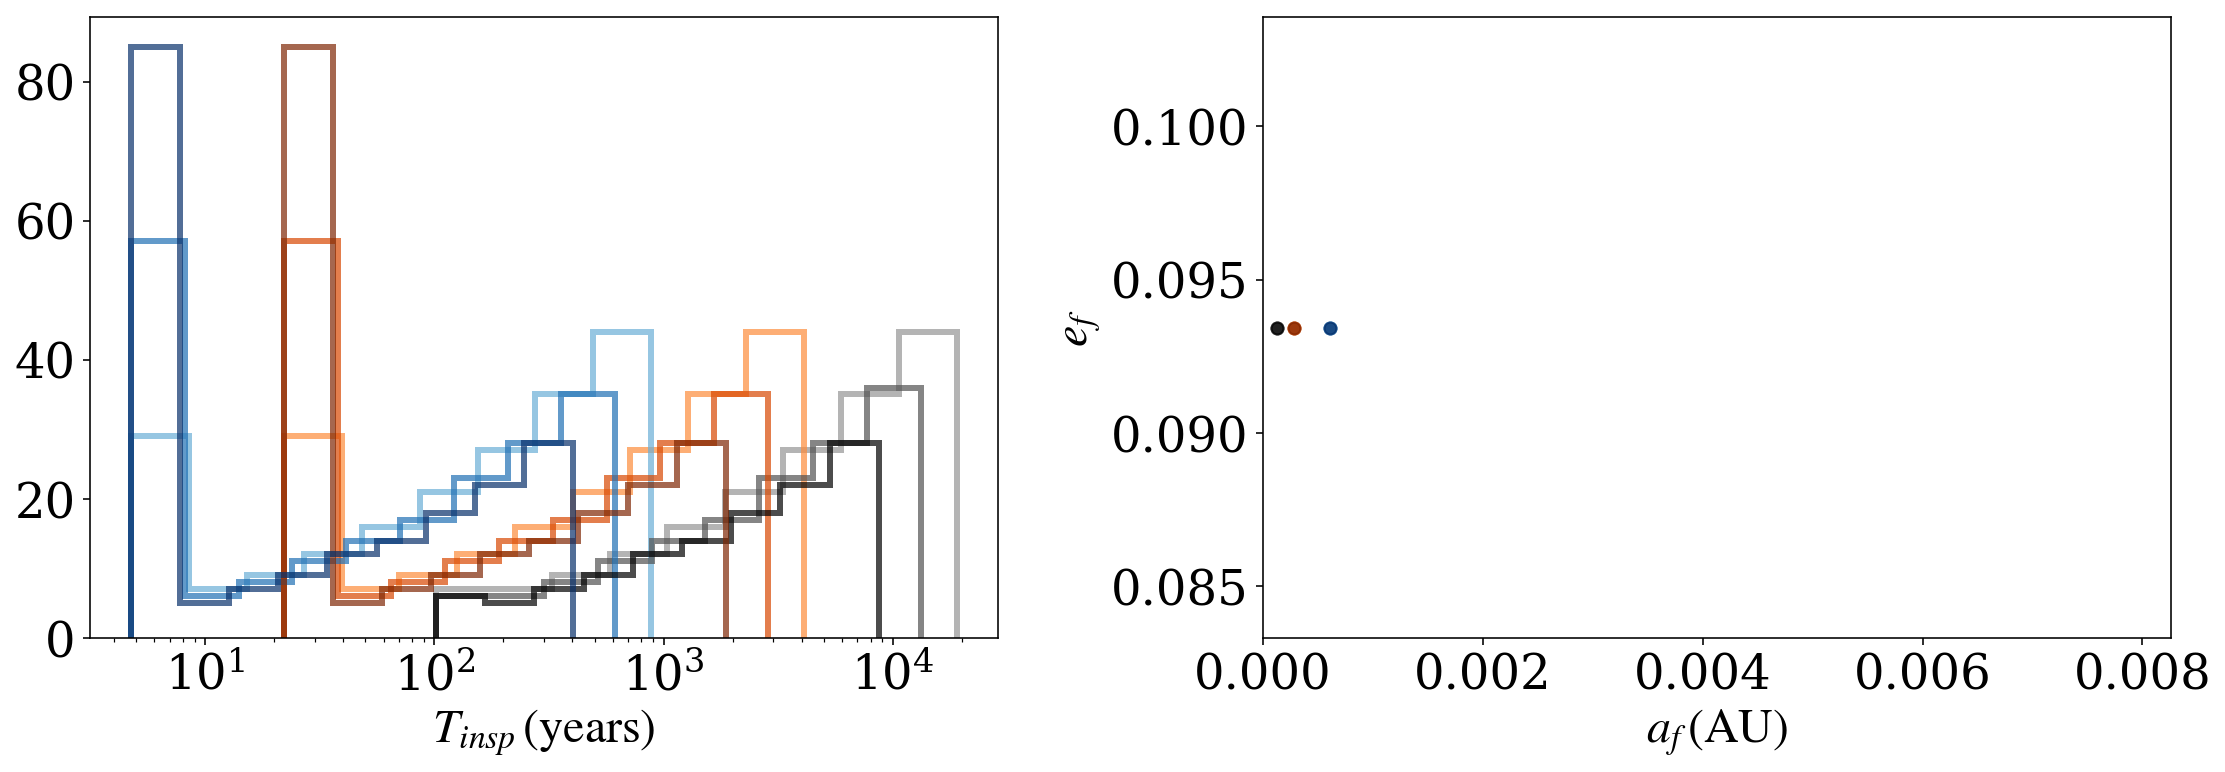

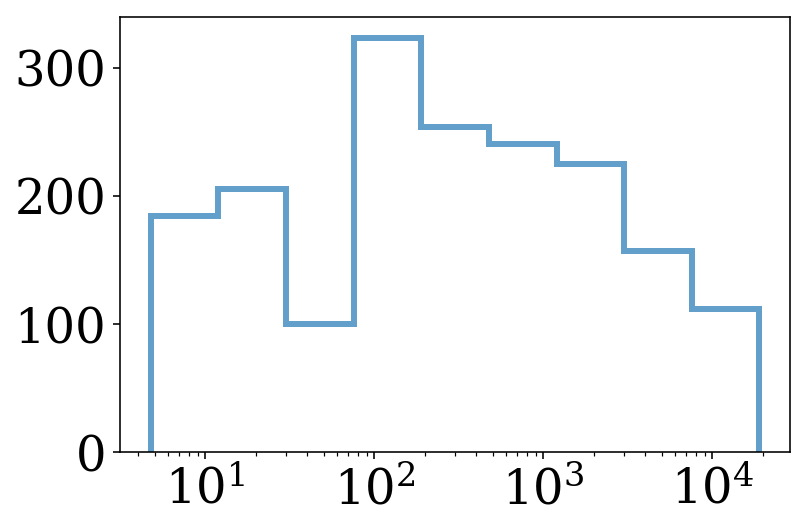

In [14]:
##Calculate inspiral time and compare to tidal circulization time
M_wd = 0.6; R_wd = R_WD(0.6)
M_imbh=[1e2, 1e3, 1e4]; M_smbh = [1e5,1e6,1e7]

cs = [[],[],[]]
cs[0]=cm.Greys(np.linspace(0.5, 1, 3))
cs[1]=cm.Oranges(np.linspace(0.5, 1, 3))
cs[2]=cm.Blues(np.linspace(0.5, 1, 3))

tinsp_tot = []
fig, ax = plt.subplots(ncols=2, figsize=(16,6))
for ii in range(len(M_smbh)):
    for jj in range(len(M_imbh)):
        t_insp = []
        r_cap_array = np.array(R_cap_smbh[ii][jj])
        for xx in range(len(r_cap_array)):
            if r_cap_array[xx] < (M_imbh[jj]/M_wd)**(1./3.):
                r_cap_array[xx] = (M_imbh[jj]/M_wd)**(1./3.)
        r_cap_au = r_cap_array*R_wd/AU_Rsun
        sma_au = r_cap_au/(1-0.99)
        a_final = 0.4*(M_imbh[jj]/M_wd)**(1./3.)*R_wd/AU_Rsun
        t_tmp, sma_f, e_f = lisa_calc.inspiral_time_peters(sma_au,0.99,M_imbh[jj],M_wd,af=a_final)  ##in Gyr
        t_insp.append(t_tmp*1e9)
        tinsp_tot+=list(t_tmp*1e9)
        ax[0].hist(t_insp, bins = np.logspace(np.log10(np.min(t_insp)), np.log10(np.max(t_insp)), 10),
                color = cs[jj][ii], histtype='step', alpha=0.7, lw=3)
        ax[1].scatter(sma_f, e_f, c = cs[jj][ii], alpha=0.7)
        
ax[0].set_xscale('log')
ax[0].set_xlabel(r'$T_{insp}\,(\rm{years})$')

ax[1].set_xlim(xmin=0)
ax[1].set_xlabel(r'$a_f\,(\rm{AU})$')
ax[1].set_ylabel(r'$e_f$')

fig.tight_layout()

plt.figure()
plt.hist(tinsp_tot, bins = np.logspace(np.log10(np.min(tinsp_tot)), np.log10(np.max(tinsp_tot)), 10),
                histtype='step', alpha=0.7, lw=3)
plt.xscale('log')

In [15]:
sys.path.insert(1, '/projects/b1095/syr904/MyCodes/PythonCodes/eXtremeGravityInstitute-LISA_Sensitivity-defe1d7/')
import PhenomA as pa
import LISA as li
import WaveformTools as wt

# create LISA object
lisa = li.LISA() 

def f_t(Mimbh, Mwd, time, Rtidal):  ##time in sec
    Mtot = Mimbh+Mwd
    Mchirp = ((Mimbh*Mwd)**3/Mtot)**(1/5)
    f_ini = np.sqrt(Gconst/Rsun**3*Msun*Mtot/Rtidal**3)/np.pi
    A = Gconst_sun*Mchirp*(PC/1e5)/(clight/1e5)**3  ##in sec
    f_time = 1/(4*twopi*A)*(5*A/time)**(3./8.)
    f_time2 = f_ini+96./5.*np.pi**(8./3.)*A**(5./3.)*f_ini**(11./3.)*time
    
    return f_time, np.log(f_time)-np.log(f_ini), np.log(f_time2)-np.log(f_ini)
    
print(f_t(1000, 0.6, 4*yearsc, 20*0.013))
    
def f_gw(Mimbh, Mwd, Rtidal):
    Mtot = Mimbh+Mwd
    return np.sqrt(Gconst/Rsun**3*Msun*Mtot/Rtidal**3)/np.pi

def character_strain(Mimbh, Mwd, Rtidal, Tobs, Dist):  ##Dist in Mpc
    hc = 8./np.sqrt(5)*Gconst**2/clight**4*Mimbh*Mwd*Msun**2/(Dist*1e6*PC*Rtidal*Rsun)*np.sqrt(Tobs*yearsc*f_gw(Mimbh, Mwd, Rtidal))
    
    return hc

#def SNR(Mimbh, Mwd, Dist, Rtidal, Tobs):  ##Dist in Mpc
#    m1 = Mimbh*pa.TSUN 
#    m2 = Mwd*pa.TSUN
#    Dl = Dist*wt.MPC
#    f_start  = f_gw(Mimbh, Mwd, Rtidal)
#    print(f_start)
#    binary = wt.Binary(m1, m2, Dl=Dl)
#    binary.f_start = f_start
#    binary.SetFreqBounds(lisa)
#    print(binary.SetFreqBounds(lisa))
#    freqs, X_char = binary.CalcStrain(lisa)
#    #freqs = f_gw(Mimbh, Mwd, Rtidal)
#    h_char = character_strain(Mimbh, Mwd, Rtidal, Tobs, Dist)
#    print(h_char)
#    binary.Figure_Type = 'point'
#    print(freqs[0], X_char[0])
#    print(lisa.Sn(f_start))
#    #snrSQ = (X_char**2/np.sqrt(freqs)/lisa.Sn(freqs))
#    snr = binary.CalcSNR(freqs[0], X_char[0], lisa)
#    #snr = snrSQ**0.5
#    return snr

def SNR(Mimbh, Mwd, Dist, Rtidal, Tobs): ##Dist in Mpc
    hc = 8./np.sqrt(5)*Gconst**2/clight**4*Mimbh*Mwd*Msun**2/(Dist*1e6*PC*Rtidal*Rsun)*np.sqrt(Tobs*yearsc*f_gw(Mimbh, Mwd, Rtidal))
    Mtot = Mimbh+Mwd
    fc = np.sqrt(Gconst/Rsun**3*Msun*Mtot/Rtidal**3)/np.pi
    
    snr_c = np.sqrt(hc**2/(fc*lisa.Sn(fc)))
    
    return snr_c
    

print(SNR(1000, 0.6, 10, 0.2, 4))

(0.029848398020277896, -0.47128027142082773, 0.8405925669468708)
33.41137954038548


5.974160554869504 11.494715862787038
27.77939603378758 53.45375880278559
128.96417076643678 248.16776108698446
5.979726005452499 11.503657718270377
27.805381080011912 53.48989340945499
129.0885303115268 248.3183346058078
5.974322891943137 11.485255134937857
27.780139124059126 53.41145233656883
128.96644732524464 247.97679882820418


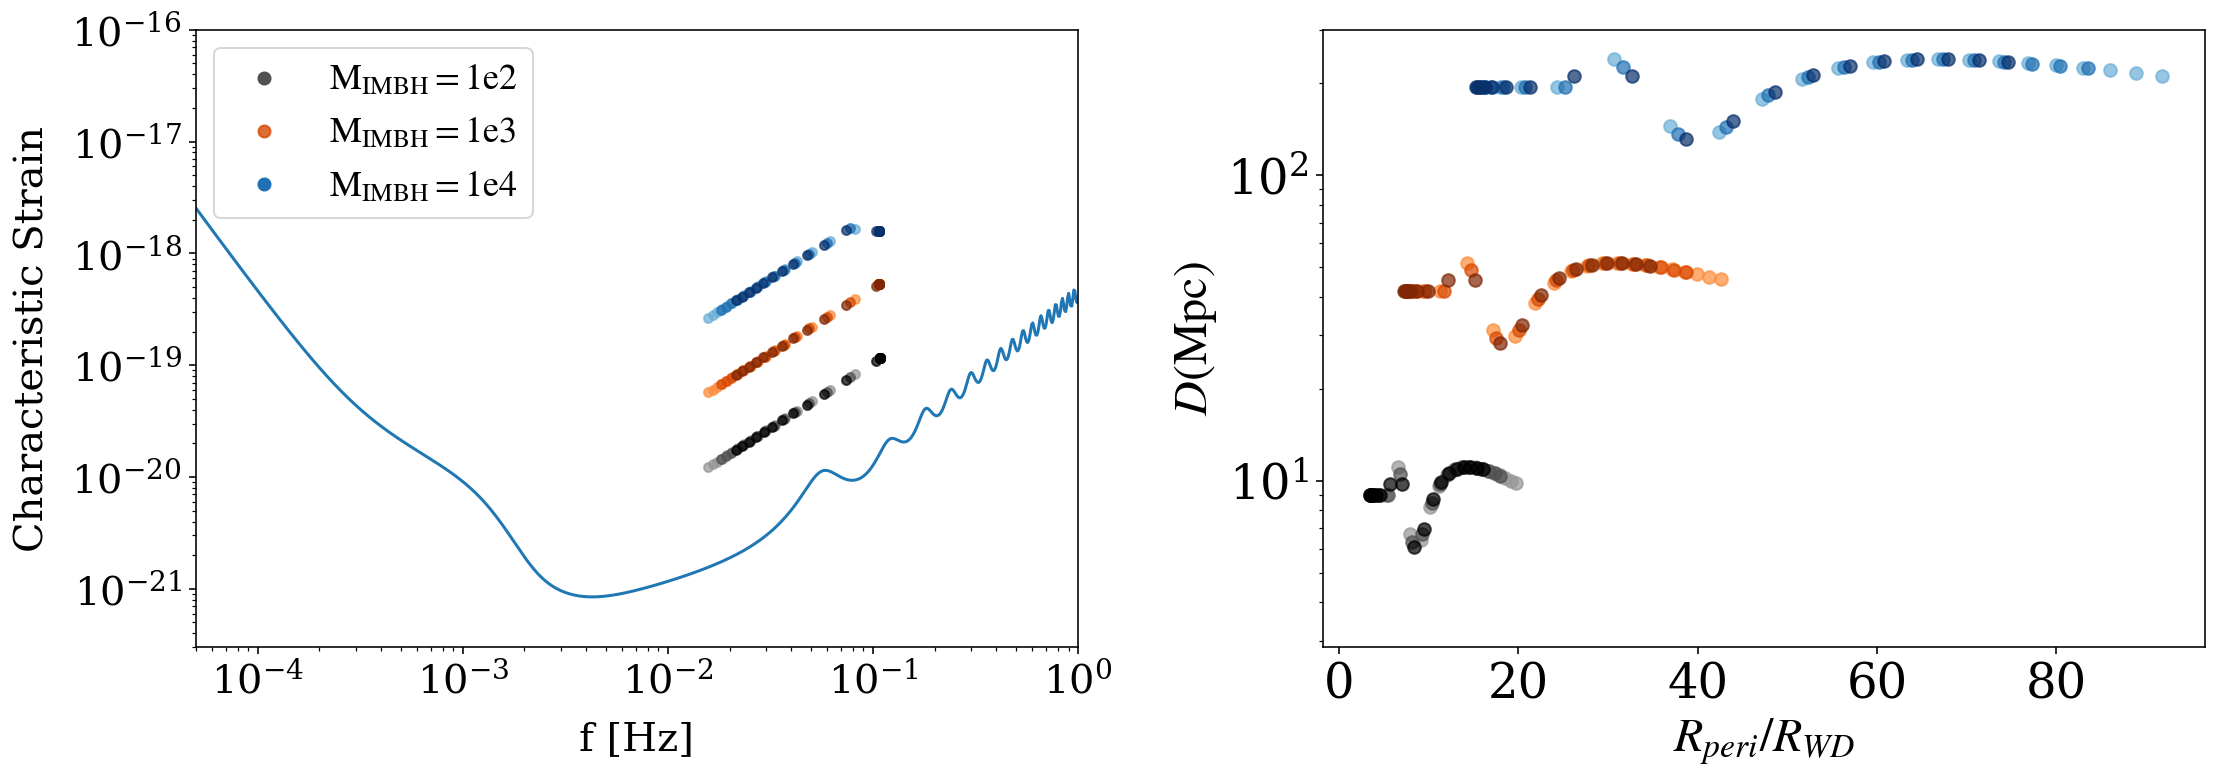

In [16]:
##GW signal
#########################################################
##LISA object options
##       Tobs, default=4 yr ---- example: lisa = li.LISA(Tobs=li.YEAR)
##       Larm, default=2.5e9 (meters)
##       NC, default=2 (number of data channels, 1 or 2)
#########################################################

# Plot LISA's sensitivity curve
f  = np.logspace(np.log10(1.0e-5), np.log10(1.0e0), 1000)
Sn = lisa.Sn(f)

##Calculate burst signal
cs = [[],[],[]]
cs[0]=cm.Greys(np.linspace(0.5, 1, 3))
cs[1]=cm.Oranges(np.linspace(0.5, 1, 3))
cs[2]=cm.Blues(np.linspace(0.5, 1, 3))

greydot=mlines.Line2D([], [], linestyle = 'None', marker = 'o', color=cs[0][1],
                  label=r'$\rm{M_{IMBH}=1e2}$')
orangedot=mlines.Line2D([], [], linestyle = 'None', marker = 'o', color=cs[1][1],
                  alpha=0.8, label=r'$\rm{M_{IMBH}=1e3}$')
bluedot=mlines.Line2D([], [], linestyle = 'None', marker = 'o', color=cs[2][1],
                  label=r'$\rm{M_{IMBH}=1e4}$')

M_wd = 0.6; R_wd = R_WD(0.6)
M_imbh=[1e2, 1e3, 1e4]; M_smbh = [1e5,1e6,1e7]
test_range=np.linspace(0.001,250,300)  ##in Mpc
snr_min = 8

fig, ax = plt.subplots(ncols=2, figsize=(16,6))
for ii in range(len(M_smbh)):
    for jj in range(len(M_imbh)):
        r_cap_array = np.array(R_cap_smbh[ii][jj])*R_wd
        for xx in range(len(r_cap_array)):
            if r_cap_array[xx]< (M_imbh[jj]/M_wd)**(1./3.)*R_wd:
                r_cap_array[xx] = (M_imbh[jj]/M_wd)**(1./3.)*R_wd
                
        r_cap_au = r_cap_array/AU_Rsun
        sma_au = r_cap_au/(1-0.95)
        a_final = (M_imbh[jj]/M_wd)**(1./3.)*R_wd/AU_Rsun
        t_tmp, sma_f, e_f = lisa_calc.inspiral_time_peters(sma_au,0.95,M_imbh[jj],M_wd,af=a_final)  ##in Gyr
        t_insp = np.array(t_tmp)*1e9

        for xx in range(len(t_insp)):
            if t_insp[xx]>4.:
                t_insp[xx]=4.
        
        H_gw = character_strain(M_imbh[jj], M_wd, r_cap_array, t_insp, 10)
        F_gw = f_gw(M_imbh[jj], M_wd, r_cap_array)
        ax[0].scatter(F_gw[::10], H_gw[::10], color=cs[jj][ii], s=20, alpha=0.7)
        
        snr_all = []
        for xx in range(len(r_cap_array)):
            f_snr = lambda x: SNR(M_imbh[jj], M_wd, x, r_cap_array[xx], 4) - snr_min
            root_range=[]
            root_range2=[]
            for yy in range(len(test_range)-1):
                if f_snr(test_range[yy])>=0 and f_snr(test_range[yy+1])<=0:
                    root_range.append(test_range[yy])
                    root_range.append(test_range[yy+1])
                    
                if f_snr(test_range[yy])<=0 and f_snr(test_range[yy+1])>=0:
                    root_range2.append(test_range[yy])
                    root_range2.append(test_range[yy+1])
                    
                if len(root_range)>2 or len(root_range2)>2:
                    print('more than 1 root')
                                  
            real_root = bisect(f_snr, root_range[0],root_range[1])
                
            snr_all.append(real_root)
            
        ax[1].scatter(R_cap_smbh[ii][jj][::10], snr_all[::10], color = cs[jj][ii], s = 40, alpha=0.7)
        print(np.min(snr_all), np.max(snr_all))

ax[0].set_xlabel(r'f [Hz]', fontsize=20, labelpad=10)
ax[0].set_ylabel(r'Characteristic Strain', fontsize=20, labelpad=10)
ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[0].set_xlim(5.0e-5, 1.0e0)
ax[0].set_ylim(3.0e-22, 1.0e-16)
ax[0].loglog(f, np.sqrt(f*Sn)) # plot the characteristic strain
ax[0].legend(handles = [greydot,orangedot,bluedot], loc='upper left', fontsize=18)

ax[1].set_yscale('log')
ax[1].set_xlabel(r'$R_{peri}/R_{WD}$')
ax[1].set_ylabel(r'$D(\rm{Mpc})$')

fig.tight_layout()

In [ ]:
def Lpeak(Mimbh, Mwd, Rwd):  ##in erg/s
    Rtidal = (Mimbh/Mwd)**(1./3.)*Rwd
    t_sn = 24.*3600. ##sec
    t_fb = twopi*np.sqrt((Rtidal/PC_Rsun)**3/(Gconst_sun*Mimbh/(PC/10**5)**2))  ##in sec
    M_fbdot = Mwd/3/t_fb   ##Msun/sec
    R_g = Gconst_sun*Mimbh/(clight/10**5)**2*PC_Rsun  ##in Rsun
    R_bh = 6*R_g
    p=0.7
    M_bhdot = M_fbdot*(R_bh/Rtidal/2.)**p ##in Msun/sec
    
    return 0.1*M_bhdot*Msun*clight**2*(t_sn/t_fb)**(-5/3)

print(Lpeak(1000, 0.6, 50*0.012))

In [ ]:
##Calculate peak luminosity of the TDEs
cs = [[],[],[]]
cs[0]=cm.Greys(np.linspace(0.5, 1, 3))
cs[1]=cm.Oranges(np.linspace(0.5, 1, 3))
cs[2]=cm.Blues(np.linspace(0.5, 1, 3))

greyline=mlines.Line2D([], [],  linestyle = '-', color=cs[0][1],
                  label=r'$\rm{M_{IMBH}=1e2}$')
orangeline=mlines.Line2D([], [],  linestyle = '-', color=cs[1][1],
                  alpha=0.8, label=r'$\rm{M_{IMBH}=1e3}$')
blueline=mlines.Line2D([], [],  linestyle = '-', color=cs[2][1],
                  label=r'$\rm{M_{IMBH}=1e4}$')

M_wd = 0.6; R_wd = R_WD(0.6)
M_imbh=[1e2, 1e3, 1e4]; M_smbh = [1e5,1e6,1e7]

#fig, ax = plt.subplots(1, figsize=(8,6))
for ii in range(len(M_smbh)):
    for jj in range(len(M_imbh)):
        r_cap_array = np.array(R_cap_smbh[ii][jj])*R_wd
        L_pk = Lpeak(M_imbh[jj], M_wd, R_wd)
        #ax.plot(r_cap_array/R_wd, L_pk, color=cs[jj][ii], alpha=0.7, lw=3)
        print(L_pk)

#ax.set_xscale('log')
##ax.set_yscale('log')
#ax.set_xlabel(r'$R_{peri}/R_{WD}$')
#ax.set_ylabel(r'$L_{peak}\,\rm{(erg\,s^{-1})}$')
#ax.legend(handles = [greyline,orangeline,blueline], loc='best', fontsize=18)